<img src="https://raw.githubusercontent.com/codecaviar/digital_asset_management/master/assets/bingyune-and-company-logo-6400x3600.png" align="left" width="200" height="auto"/>

<br/><br/><br/><br/>

# Patient Safety: Receive Quality Care or Your Autopsy Is Free 

**BingYune Chen**, Principal Data Scientist<br>
2020-06-04 | 11 minute read

Data is provided by [MIT MIMIC-III](https://mimic.physionet.org/) 
    | Source code is on [Github](https://github.com/codecaviar)

----------

The goal of this project is to estimate a patient's full length of stay (LOS) at the time of admission to the hospital. The inputs to the prediction model include features such as a patient's age, gender, race, and diagnosis category (e.g. heart disease, delivery, injury, poisoning, etc.). 

## Table of Contents

1. [**Project Overview**](#overview)
2. [**Data Exploration**](#data_exploration) 
3. [**Prediction Model**](#prediction)    
4. [**Results**](#results)
5. [**Conclusion**](#conclusion)

<a class="anchor" id="overview"></a>
# 1. Project Overview

Due to the growing number of hospitalized COVID-19 patients, predicting the length of stay has become increasingly important for both resource planning and effective admission scheduling. Length of stay (LOS) is defined as the number of days from the initial admit date to the date that the patient is discharged from any given healthcare facility. LOS estimates are useful for planning the available bed capacity, the number of specialists needed on call, and the potential discharge dates for patients to safely return home. Advanced LOS estimates at the time of admission can also greatly enhance the quality of care for patients. For instance, hospitals having longer than expected LOS numbers have a higher risk of patients developing hospital-acquired infections. On the other hand, if hospitals prematurely discharge patients to reduce costs, then lower than expected LOS numbers could be an indication of poor quality care at the facility.

<a class="anchor" id="problem_statement"></a>
## 1.1 Problem Statement

> The goal of this project is to estimate a patient's full Length of Stay (LOS) at the time of admission to the hospital.

Rather than predicting the exact LOS for hospitalized patients, the project aims to predict short-term vs. long-term LOS of each patient, where a LOS less than or equal to 5 days is considered to be short-term. The threshold of less than or equal to 5 days is chosen because 5 is close to the mean, median, and mode for the distribution of LOS, especially when we remove outliers of more than 20 days. 

The inputs to the prediction model also include features that account for each patient's level of risk such as age, gender, race, and diagnosis category (e.g. heart disease, delivery, injury, poisoning, etc.). The MIT MIMIC-III database met the data requirements and was selected for this project. [MIMIC](https://mimic.physionet.org/) is described as the following: “MIMIC is an openly available dataset developed by the MIT Lab for Computational Physiology, comprising deidentified health data associated with ~60,000 intensive care unit admissions. It includes demographics, vital signs, laboratory tests, medications, and more.” The database contained deidentified health data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center in Boston, MA between 2001 and 2012.

In order to access the MIT MIMIC-III database, the author was required to complete a [training course](https://about.citiprogram.org/en/homepage/) on the ethical regulations that guide research involving human subjects and fill out a research [application form](https://physionet.org). Because of the above data access requirements, the GitHub repo associated with this notebook only references filenames and does not contain actual data files. 

<a class="anchor" id="metrics"></a>
## 1.2 Metrics

The project evaluates the area under the curve (AUC), accuracy (ACC), and F1-score (F1S) measures for the selected machine learning algorithms, in order to choose the best one to optimize. The selected machine learning algorithms are explored in more detail in the modeling section of this project. In terms of the selected metrics:

**AUC - ROC** is a performance measurement for a classification problem at various thresholds settings. ROC (Receiver Operator Characteristic Curve) is a probability curve, while the AUC represents the degree or measure of separability. The AUC tells how well the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. For this project, the higher the AUC, the better the model is at distinguishing between patients with a short-term LOS vs. long-term LOS. ROC is generated by plotting the True Positive Rate (TPR or "sensitivity") on the y-axis against the False Positive Rate (FPR or "1-Specificity") on the x-axis. 

<br/>
<img src="assets/fig1-metric-true-positive-rate.png"> 
<br/>
<img src="assets/fig1_1-metric-false-positive-rate.png"> 
<p style="text-align:center"> Fig.1. Metric, formula to calculate true positive and false positive rates </p>

True Positive Rate indicates what proportion of people 'having short-term LOS' were correctly classified. False Positive Rate indicates the proportion of people classified as 'not having short-term LOS', that are False Positives.

**Accuracy** measures the fraction of predictions the model predicted correctly over the total number of possible predictions. For binary classification, accuracy can also be calculated in terms of positives and negatives. TP, FN, FP, and TN are the number of true positives, false negatives, false positives and true negatives respectively.

<br/>
<img src="assets/fig2-metric-accuracy.png">
<p style="text-align:center"> Fig.2. Metric, formula to calculate accuracy </p>

**F1 Score** measures accuracy, but it also considers both the precision (p) and the recall (r) of the test to compute the score: p is the number of correct positive results divided by the number of all positive results returned by the classifier, and r is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive).

<br/>
<img src="assets/fig3-metric-f1.png">
<p style="text-align:center"> Fig.3. Metric, formula to calculate F1 score </p>

In [ ]:
# Import libraries for pandas, numpy, matplotlib, sklearn, etc.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from collections import defaultdict

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score 
from sklearn.metrics import make_scorer, recall_score, precision_score 
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

The following csv files were downloaded from the MIMIC-III database [source](https://mimic.physionet.org/).

In [2]:
# Import primary Admissions information
df_adm = pd.read_csv('../patient_safety_los_data/ADMISSIONS.csv')

# Import patient specific info such as gender
df_pat = pd.read_csv('../patient_safety_los_data/PATIENTS.csv')

# Import the diagnosis for each admission to hospital
df_dig = pd.read_csv('../patient_safety_los_data/DIAGNOSES_ICD.csv')

# Import Intensive Care Unit (ICU) data for each admission to hospital
df_icu = pd.read_csv('../patient_safety_los_data/ICUSTAYS.csv')

<a class="anchor" id="data_exploration"></a>
# 2. Data Exploration

In this section, the project examines the various imported MIMIC DataFrames to understand the distribution of the data. Additionally, we develop a strategy to extract the target Length of Stay (LOS) values and explore the features (independent variables) that might be useful in predicting short-term vs. long-term LOS of each patient, where a LOS less than or equal to 5 days was considered to be short-term. 

<a class="anchor" id="admissions"></a>
## 2.1 ADMISSIONS.csv Exploration 

This section explores the ADMISSIONS.csv table of the [MIMIC-III database](https://mimic.physionet.org/mimictables/admissions/): The ADMISSIONS table gives information regarding a patient's admission to the hospital. Since each unique hospital visit for a patient is assigned a unique HADM_ID, the ADMISSIONS table can be considered as a definition table for HADM_ID. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on.

In [3]:
df_adm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

In [4]:
print('Dataset has {} number of unique admission events.'.format(df_adm['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(df_adm['SUBJECT_ID'].nunique()))

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.


<a class="anchor" id="los"></a>
### 2.1.1 Length of Stay

The first task is to calculate the LOS and label as short-term (1) vs long-term (0). LOS is defined as the time between admission and discharge from the hospital.

In [5]:
# Explore the admission dataframe
df_adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [6]:
# Convert admission and discharge times to datatime type
df_adm['ADMITTIME'] = pd.to_datetime(df_adm['ADMITTIME'])
df_adm['DISCHTIME'] = pd.to_datetime(df_adm['DISCHTIME'])

# Convert timedelta type into float 'days', 86400 seconds in a day
df_adm['LOS'] = (df_adm['DISCHTIME'] - df_adm['ADMITTIME']).dt.total_seconds()/86400

# Verify the conversions are accurate
df_adm[['ADMITTIME', 'DISCHTIME', 'LOS']].head()

,ADMITTIME,DISCHTIME,LOS
0,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444
1,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528
2,2157-10-18 19:34:00,2157-10-25 14:00:00,6.768056
3,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944
4,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028


In [7]:
df_adm['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [8]:
# Explore any negative LOS values
df_adm[df_adm['LOS'] < 0]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS
425,534,417,102633,2177-03-23 16:17:00,2177-03-23 07:20:00,2177-03-23 07:20:00,URGENT,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,NaN,NaN,ORGAN DONOR ACCOUNT,1,1,-0.372917
456,237,181,102631,2153-10-12 09:49:00,2153-10-12 06:29:00,2153-10-12 06:29:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,MARRIED,WHITE,2153-10-12 06:23:00,2153-10-12 07:45:00,DISSECTING ANEURYSIM,1,1,-0.138889
692,644,516,187482,2197-07-31 20:18:00,2197-07-31 01:10:00,2197-07-31 01:10:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,WIDOWED,UNKNOWN/NOT SPECIFIED,2197-07-31 11:31:00,2197-07-31 14:35:00,RESPIRATORY DISTRESS,1,0,-0.797222
1911,1640,1334,138015,2137-09-02 14:43:00,2137-09-02 12:00:00,2137-09-02 12:00:00,NEWBORN,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,NaN,WHITE,NaN,NaN,NEWBORN,1,1,-0.113194
1970,1699,1381,181430,2189-01-02 14:25:00,2189-01-02 12:00:00,2189-01-02 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,UNOBTAINABLE,MARRIED,WHITE,2189-01-02 10:31:00,2189-01-02 15:56:00,STROKE;TELEMETRY,1,1,-0.100694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57233,57980,96810,165589,2103-09-25 20:38:00,2103-09-25 12:00:00,2103-09-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,RUSS,UNOBTAINABLE,WIDOWED,WHITE,2103-09-25 19:27:00,2103-09-25 21:37:00,CARDIAC ARREST,1,1,-0.359722
57559,58635,98943,193747,2164-11-14 20:03:00,2164-11-14 12:00:00,2164-11-14 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,UNOBTAINABLE,MARRIED,WHITE,2164-11-14 18:24:00,2164-11-14 20:54:00,INTRACRANIAL HEMORRHAGE,1,1,-0.335417
57902,58720,99207,191004,2143-07-06 19:59:00,2143-07-06 12:00:00,2143-07-06 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,ENGL,CATHOLIC,DIVORCED,WHITE,2143-07-06 19:30:00,2143-07-06 20:05:00,GSW L. CHEST WALL & ABDOMEN,1,1,-0.332639
58346,55950,90642,101946,2122-04-24 14:36:00,2122-04-24 12:00:00,2122-04-24 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,MARRIED,UNABLE TO OBTAIN,NaN,NaN,ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION\CATH,1,1,-0.108333


In [9]:
# Remove LOS with negative numbers, likely user input error
df_adm = df_adm[df_adm['LOS'] > 0] 

Patients who died at the hospital are also dropped from the DataFrame (at the end of the Data Wrangling section), as those values would likely bias the short-term vs. long-term LOS calculations. Patients who died at the hospital never actually get "discharged" from the hospital, so LOS would be shorter for this group (e.g. negative values). 

In [10]:
# Mark admissions where patients died in boolean column
df_adm['DECEASED'] = df_adm['DEATHTIME'].notnull().map({True:1, False:0})

print("{} of {} patients died in the hospital".format(df_adm['DECEASED'].sum(), 
                                                     df_adm['SUBJECT_ID'].nunique()))

5774 of 46445 patients died in the hospital


In [11]:
# Look at statistics for LOS not including admissions resulting in death
df_adm['LOS'].loc[df_adm['DECEASED'] == 0].describe()

count    53104.000000
mean        10.138174
std         12.284461
min          0.014583
25%          3.866667
50%          6.565972
75%         11.711632
max        294.660417
Name: LOS, dtype: float64

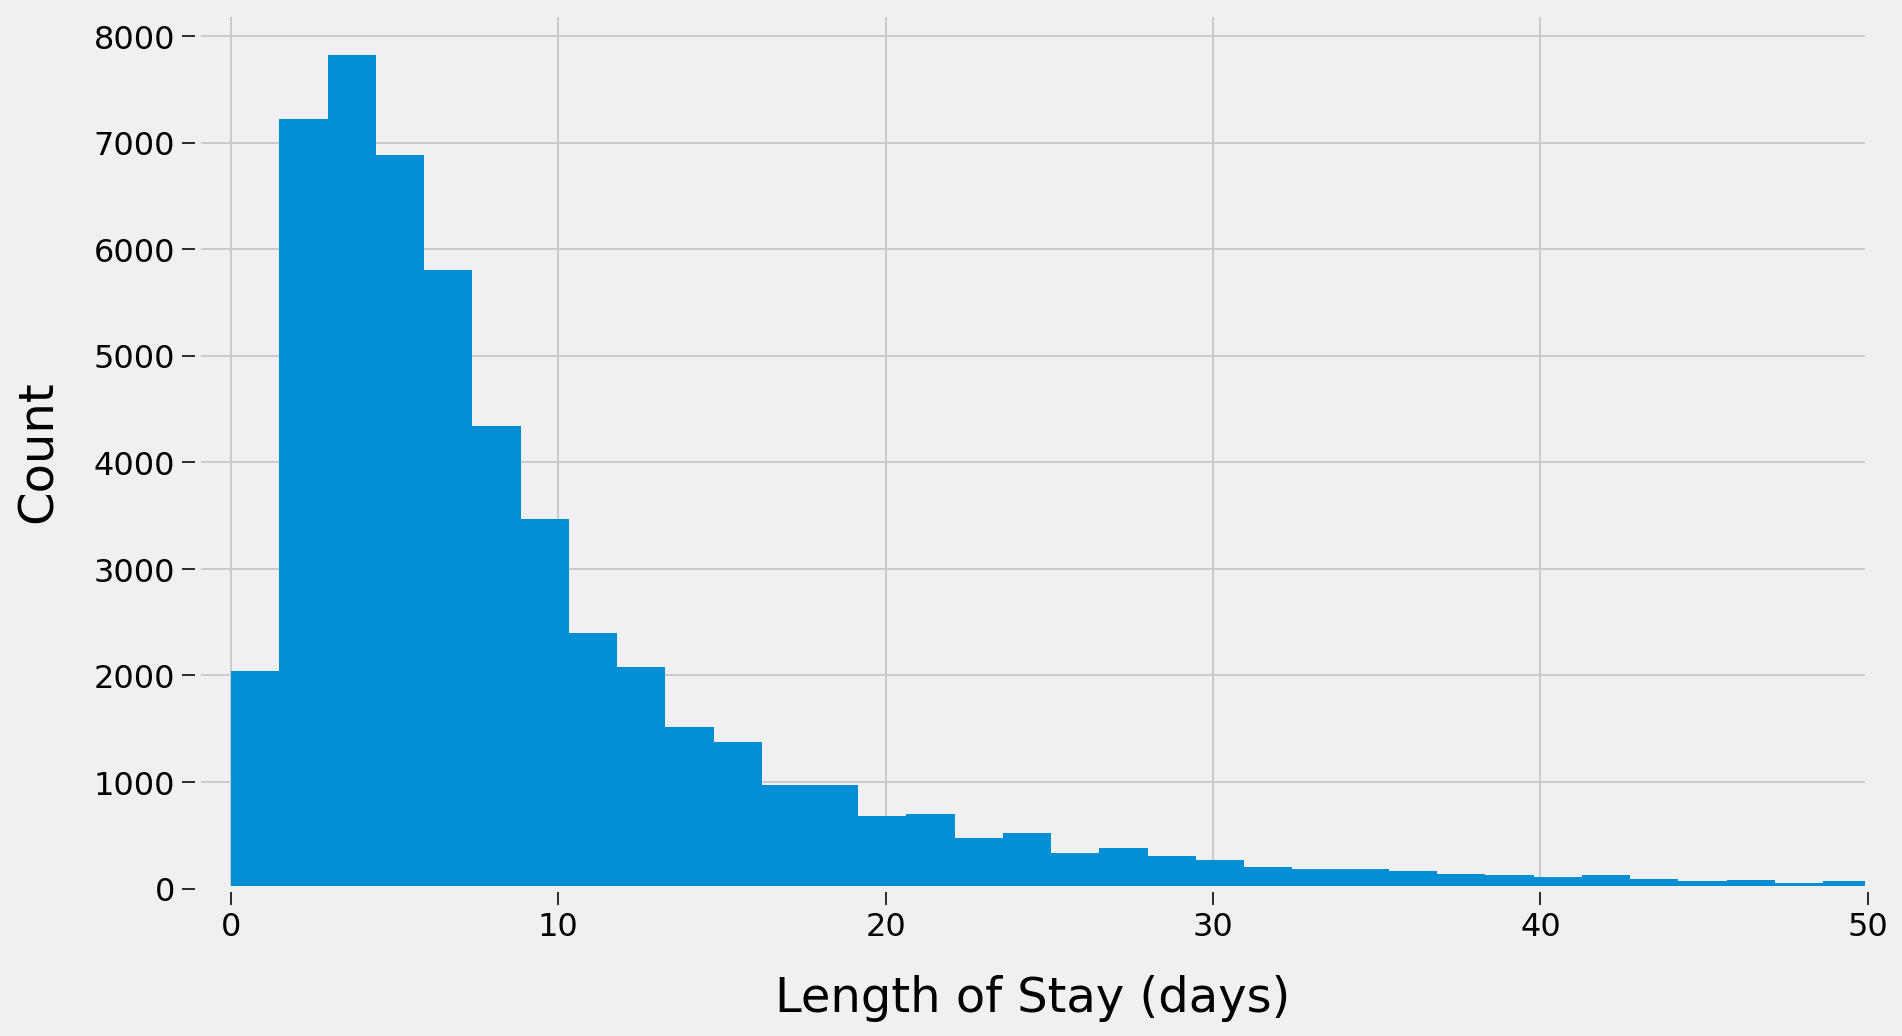

In [12]:
# Plot LOS distribution, not including deceased
fig,ax = plt.subplots(figsize=(13.33, 7.5))
ax.hist(df_adm['LOS'].loc[df_adm['DECEASED'] == 0], bins=200)

ax.set_xlim(-1, 50)
ax.set_xlabel('Length of Stay (days)', size=24, labelpad=16)
ax.set_ylabel('Count', size=24, labelpad=16)
ax.tick_params(axis='both', labelsize=16, length=8)

plt.show();

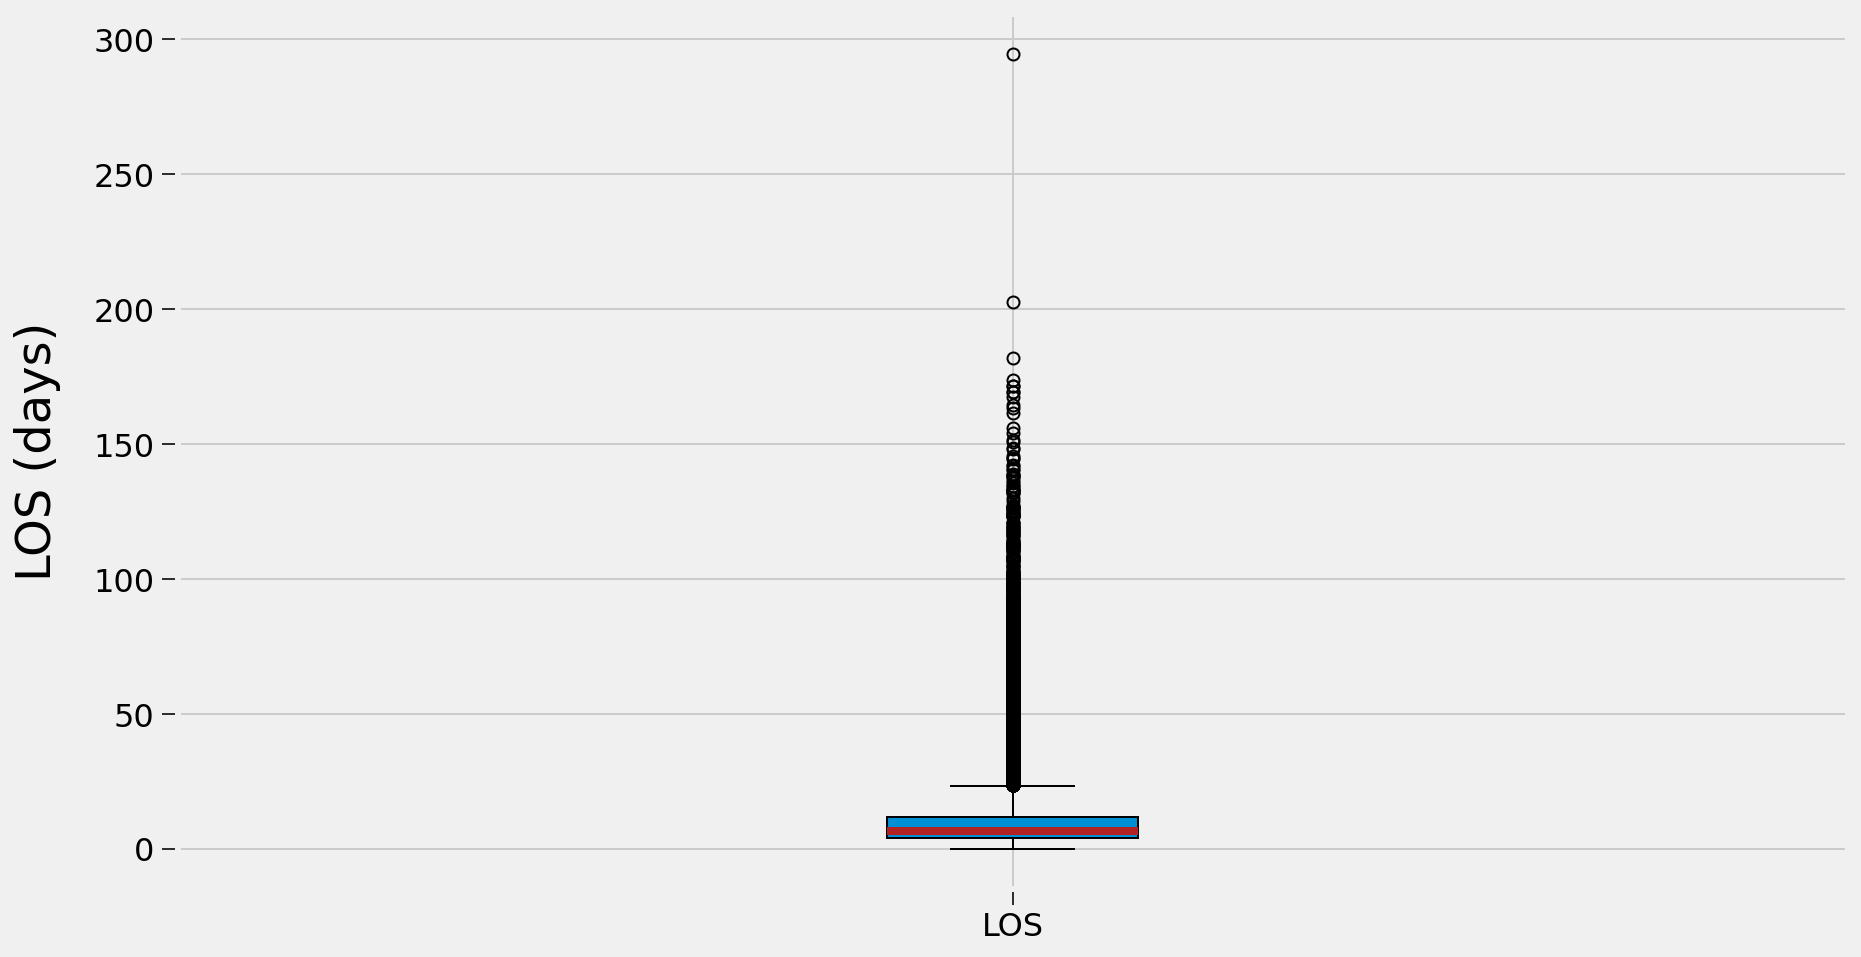

In [13]:
# Plot LOS boxplot, not including deceased, check for outliers
fig,ax = plt.subplots(figsize=(13.33, 7.5))
medianprops = dict(linestyle='-', linewidth=4, color='firebrick')
ax.boxplot(df_adm['LOS'].loc[df_adm['DECEASED'] == 0], labels=['LOS'], 
           patch_artist=True, medianprops=medianprops)

ax.set_ylabel('LOS (days)', size=24, labelpad=16)
xtick_names = plt.setp(ax, xticklabels=['LOS'])
plt.setp(xtick_names, size=16)
plt.tick_params(axis='both', labelsize=16, length=8) 

plt.show();

In [14]:
# Find cutoff point for outliers
df_adm['LOS'].loc[df_adm['DECEASED'] == 0].describe()

count    53104.000000
mean        10.138174
std         12.284461
min          0.014583
25%          3.866667
50%          6.565972
75%         11.711632
max        294.660417
Name: LOS, dtype: float64

In [15]:
# Remove LOS with outlier values
df_adm = df_adm[df_adm['LOS'] <= 20] 

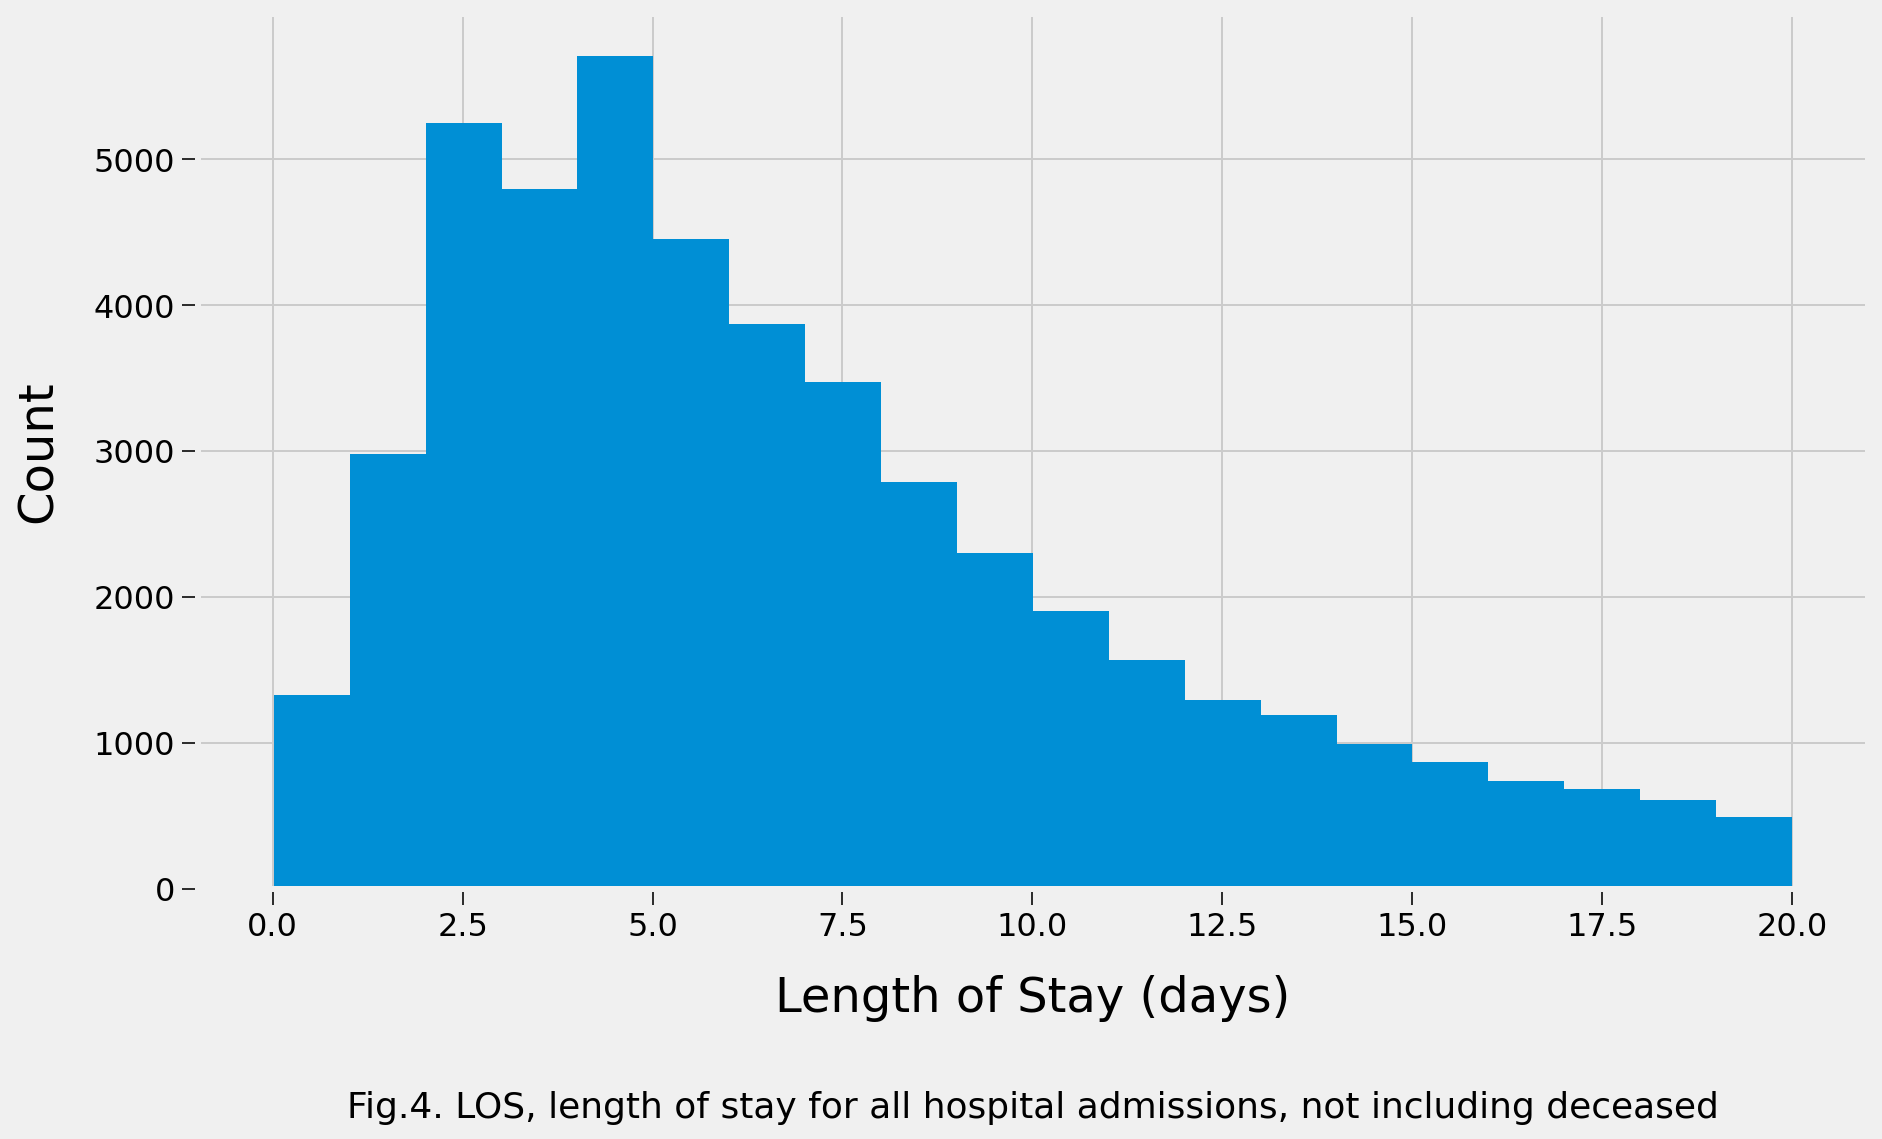

In [16]:
# Plot LOS distribution again, not including deceased
fig,ax = plt.subplots(figsize=(13.33, 7.5))
ax.hist(df_adm['LOS'].loc[df_adm['DECEASED'] == 0], bins=20)

ax.set_ylabel('Count', size=24, labelpad=16)
ax.set_xlabel('Length of Stay (days)', size=24, labelpad=16)
ax.tick_params(axis='both', labelsize=16, length=8)

# Add caption
fignum = 4
figtxt = '. LOS, length of stay for all hospital admissions, not including deceased'
figcap = 'Fig.' + str(fignum) + figtxt
ax.text(0.5, -0.25, figcap, fontsize=18, ha='center', va='center', transform=ax.transAxes)
plt.savefig('fig' + str(fignum) + '-los-hospital-admission-20days.png', bbox_inches='tight')

plt.show();

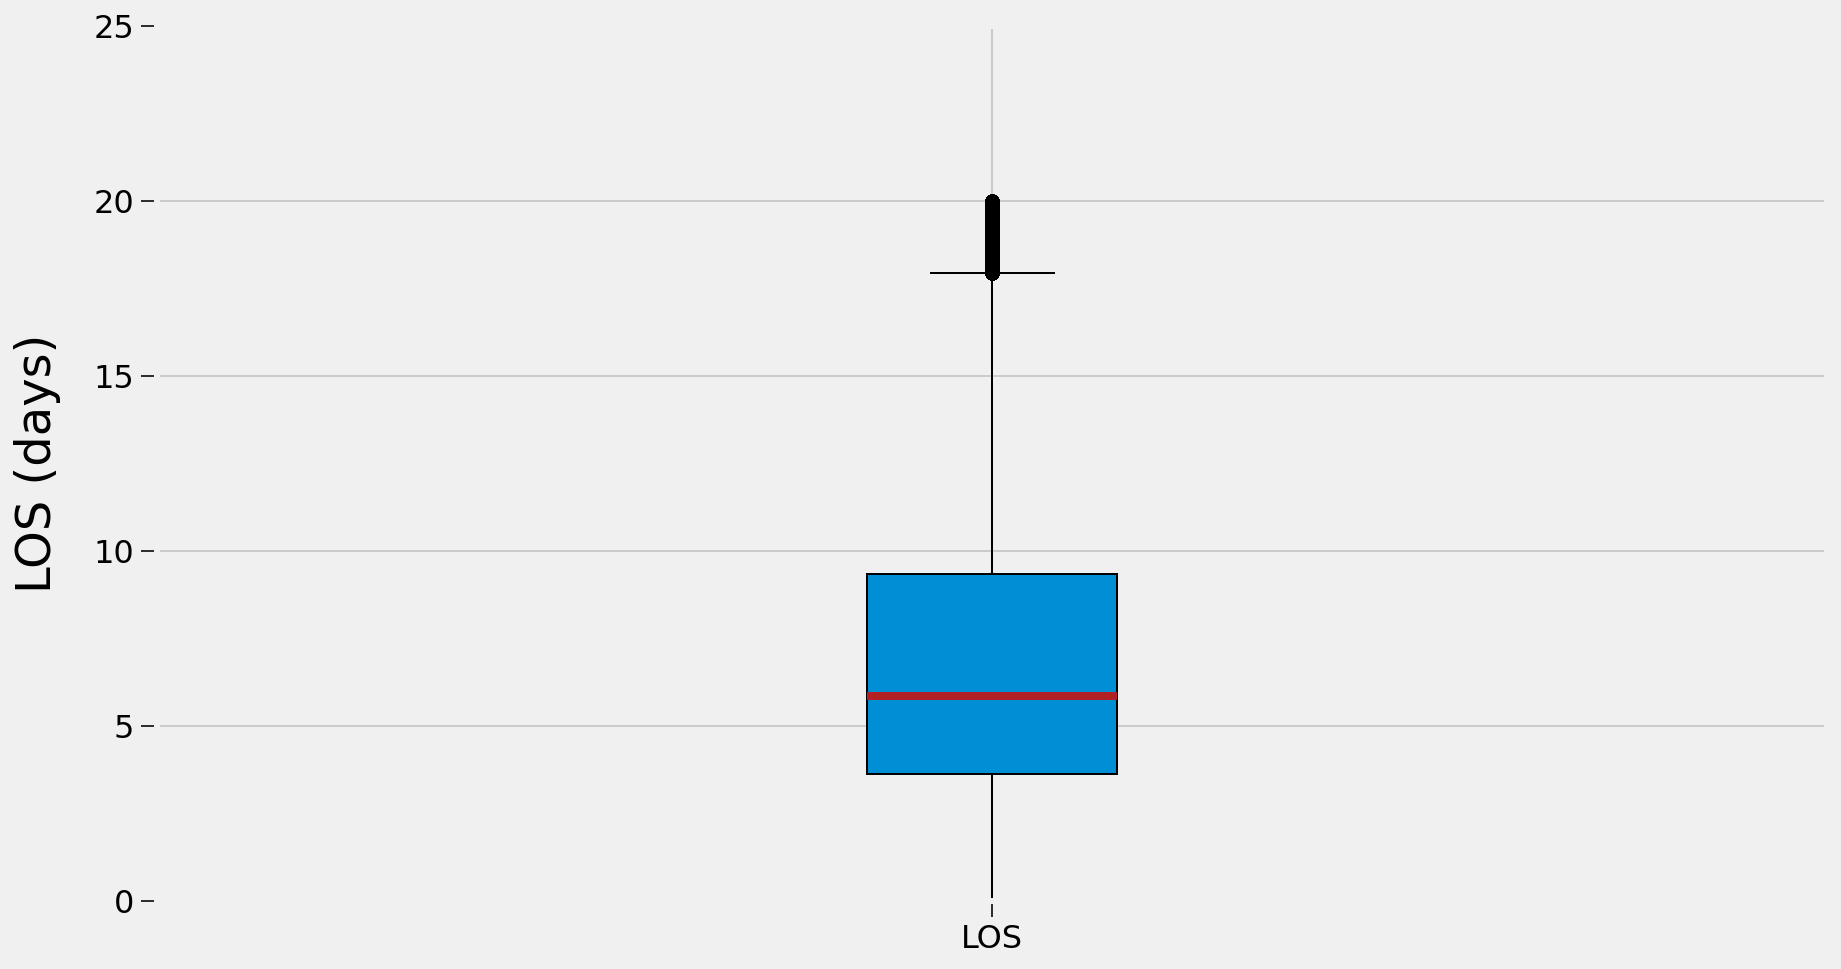

In [18]:
# Plot LOS boxplot again, not including deceased, check for outliers
fig,ax = plt.subplots(figsize=(13.33, 7.5))
medianprops = dict(linestyle='-', linewidth=4, color='firebrick')
ax.boxplot(df_adm['LOS'].loc[df_adm['DECEASED'] == 0], labels=['LOS'], patch_artist=True, medianprops=medianprops)

ax.set_ylabel('LOS (days)', size=24, labelpad=16)
ax.set_ylim(0, 25)
xtick_names = plt.setp(ax, xticklabels=['LOS'])
plt.setp(xtick_names, size=16)
plt.tick_params(axis='both', labelsize=16, length=8) 

plt.show();

In [19]:
# Find cutoff point for outliers
df_adm['LOS'].loc[df_adm['DECEASED'] == 0].describe()

count    47302.000000
mean         6.909876
std          4.460122
min          0.014583
25%          3.610417
50%          5.849306
75%          9.335417
max         19.999306
Name: LOS, dtype: float64

In [20]:
# Label rows as short-term (0) or long-term (1) LOS
df_adm.loc[df_adm['LOS'] <= 5, 'LOS_SHORT'] = 0
df_adm.loc[df_adm['LOS'] > 5, 'LOS_SHORT'] = 1
df_adm['LOS_SHORT'].loc[df_adm['DECEASED'] == 0].value_counts()

1.0    27300
0.0    20002
Name: LOS_SHORT, dtype: int64

In [21]:
# Drop some columns that will no longer be needed
df_adm.drop(columns=['DISCHTIME', 'ROW_ID', 'EDREGTIME', 'EDOUTTIME', 
                     'HOSPITAL_EXPIRE_FLAG','HAS_CHARTEVENTS_DATA'], 
            inplace=True)

<a class="anchor" id="ethnicity"></a>
### 2.1.2 Ethnicity 

The aim for this column is to better align the existing categories with the racial and ethnic categories and definitions used by the [National Institute of Health](https://grants.nih.gov/grants/guide/notice-files/not-od-15-089.html) for reporting purposes. These standards are commonly used for federal data collection purposes, not only in the decennial census, but also in household surveys, on administrative forms (e.g., school registration and mortgage lending applications), and in medical and clinical research. The revised standards contain five minimum categories for race: American Indian or Alaska Native, Asian, Black or African American, Native Hawaiian or Other Pacific Islander, and White. There are two categories for ethnicity: "Hispanic or Latino" and "Not Hispanic or Latino."

In [22]:
df_adm['ETHNICITY'].value_counts()

WHITE                                                       36420
BLACK/AFRICAN AMERICAN                                       4807
UNKNOWN/NOT SPECIFIED                                        3947
HISPANIC OR LATINO                                           1497
ASIAN                                                        1369
OTHER                                                        1305
UNABLE TO OBTAIN                                              717
PATIENT DECLINED TO ANSWER                                    497
ASIAN - CHINESE                                               244
HISPANIC/LATINO - PUERTO RICAN                                208
BLACK/CAPE VERDEAN                                            181
WHITE - RUSSIAN                                               156
MULTI RACE ETHNICITY                                          110
BLACK/HAITIAN                                                  91
WHITE - OTHER EUROPEAN                                         76
ASIAN - AS

In [23]:
# Update the ethnicity categories
df_adm['ETHNICITY'].replace(regex=r'^AMERICAN INDIAN\D*', value='AMERICAN INDIAN/ALASKA NATIVE', inplace=True)
df_adm['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df_adm['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df_adm['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df_adm['ETHNICITY'].replace(['PORTUGUESE', 'CARIBBEAN ISLAND', 'SOUTH AMERICAN'], value='HISPANIC/LATINO', inplace=True)
df_adm['ETHNICITY'].replace(regex=r'^NATIVE HAWAIIAN\D*', value='NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER', inplace=True)
df_adm['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df_adm['ETHNICITY'].replace(regex=r'^MIDDLE EASTERN', value='WHITE', inplace=True)
df_adm['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                             'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY'], value='OTHER/UNKNOWN', inplace=True)

df_adm['ETHNICITY'].value_counts()

WHITE                                     36755
OTHER/UNKNOWN                              6576
BLACK/AFRICAN AMERICAN                     5117
HISPANIC/LATINO                            1947
ASIAN                                      1810
AMERICAN INDIAN/ALASKA NATIVE                38
NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER       17
Name: ETHNICITY, dtype: int64

In [24]:
# Create a plotting function to explore each column
def plot_los_groupby(variable, fignbr=0):
    ''' 
    Plot Median LOS by categorical series name of DataFrame input
    '''
    results = df_adm[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig,ax = plt.subplots(figsize=(13.33, 7.5))
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, alpha=0.8, color='#fc4f30')
    
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)', size=24, labelpad=16)
    ax.tick_params(axis='both', labelsize=16, length=8)
    
    # Add caption
    fignum = fignbr
    figtxt = '. ' + variable.title() + ', comparison of median length of stay by category'
    figcap = 'Fig.' + str(fignum) + figtxt
    ax.text(0.5, -0.25, figcap, fontsize=18, ha='center', va='center', transform=ax.transAxes)
    plt.savefig('fig' + str(fignum) + '-' + variable.lower() + 
                '-category-comparison.png', bbox_inches='tight')
    
    plt.show();
    
# Create a boxplot function to explore each column
def boxplot_los_groupby(variable, fignbr=0, los_range=(-1, 30)):
    ''' 
    Graph boxplot of LOS by categorical series name of DataFrame input
    '''
    results = df_adm[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df_adm['LOS'].loc[df_adm[variable]==cat].values)

    fig,ax = plt.subplots(figsize=(13.33, 7.5))
    medianprops = dict(linestyle='-', linewidth=4, color='firebrick')
    ax.boxplot(hist_data, 0, '', vert=False, patch_artist=True, medianprops=medianprops)
    
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('LOS (days)', size=24, labelpad=16)
    ax.tick_params(axis='both', labelsize=16, length=8) 
    
    # Add caption
    fignum = fignbr
    figtxt = '. ' + variable.title() + ', box plot comparison of length of stay by category'
    figcap = 'Fig.' + str(fignum) + figtxt
    ax.text(0.5, -0.25, figcap, fontsize=18, ha='center', va='center', transform=ax.transAxes)
    plt.savefig('fig' + str(fignum) + '-' + variable.lower() + 
                '-feature.png', bbox_inches='tight')
    
    plt.show();

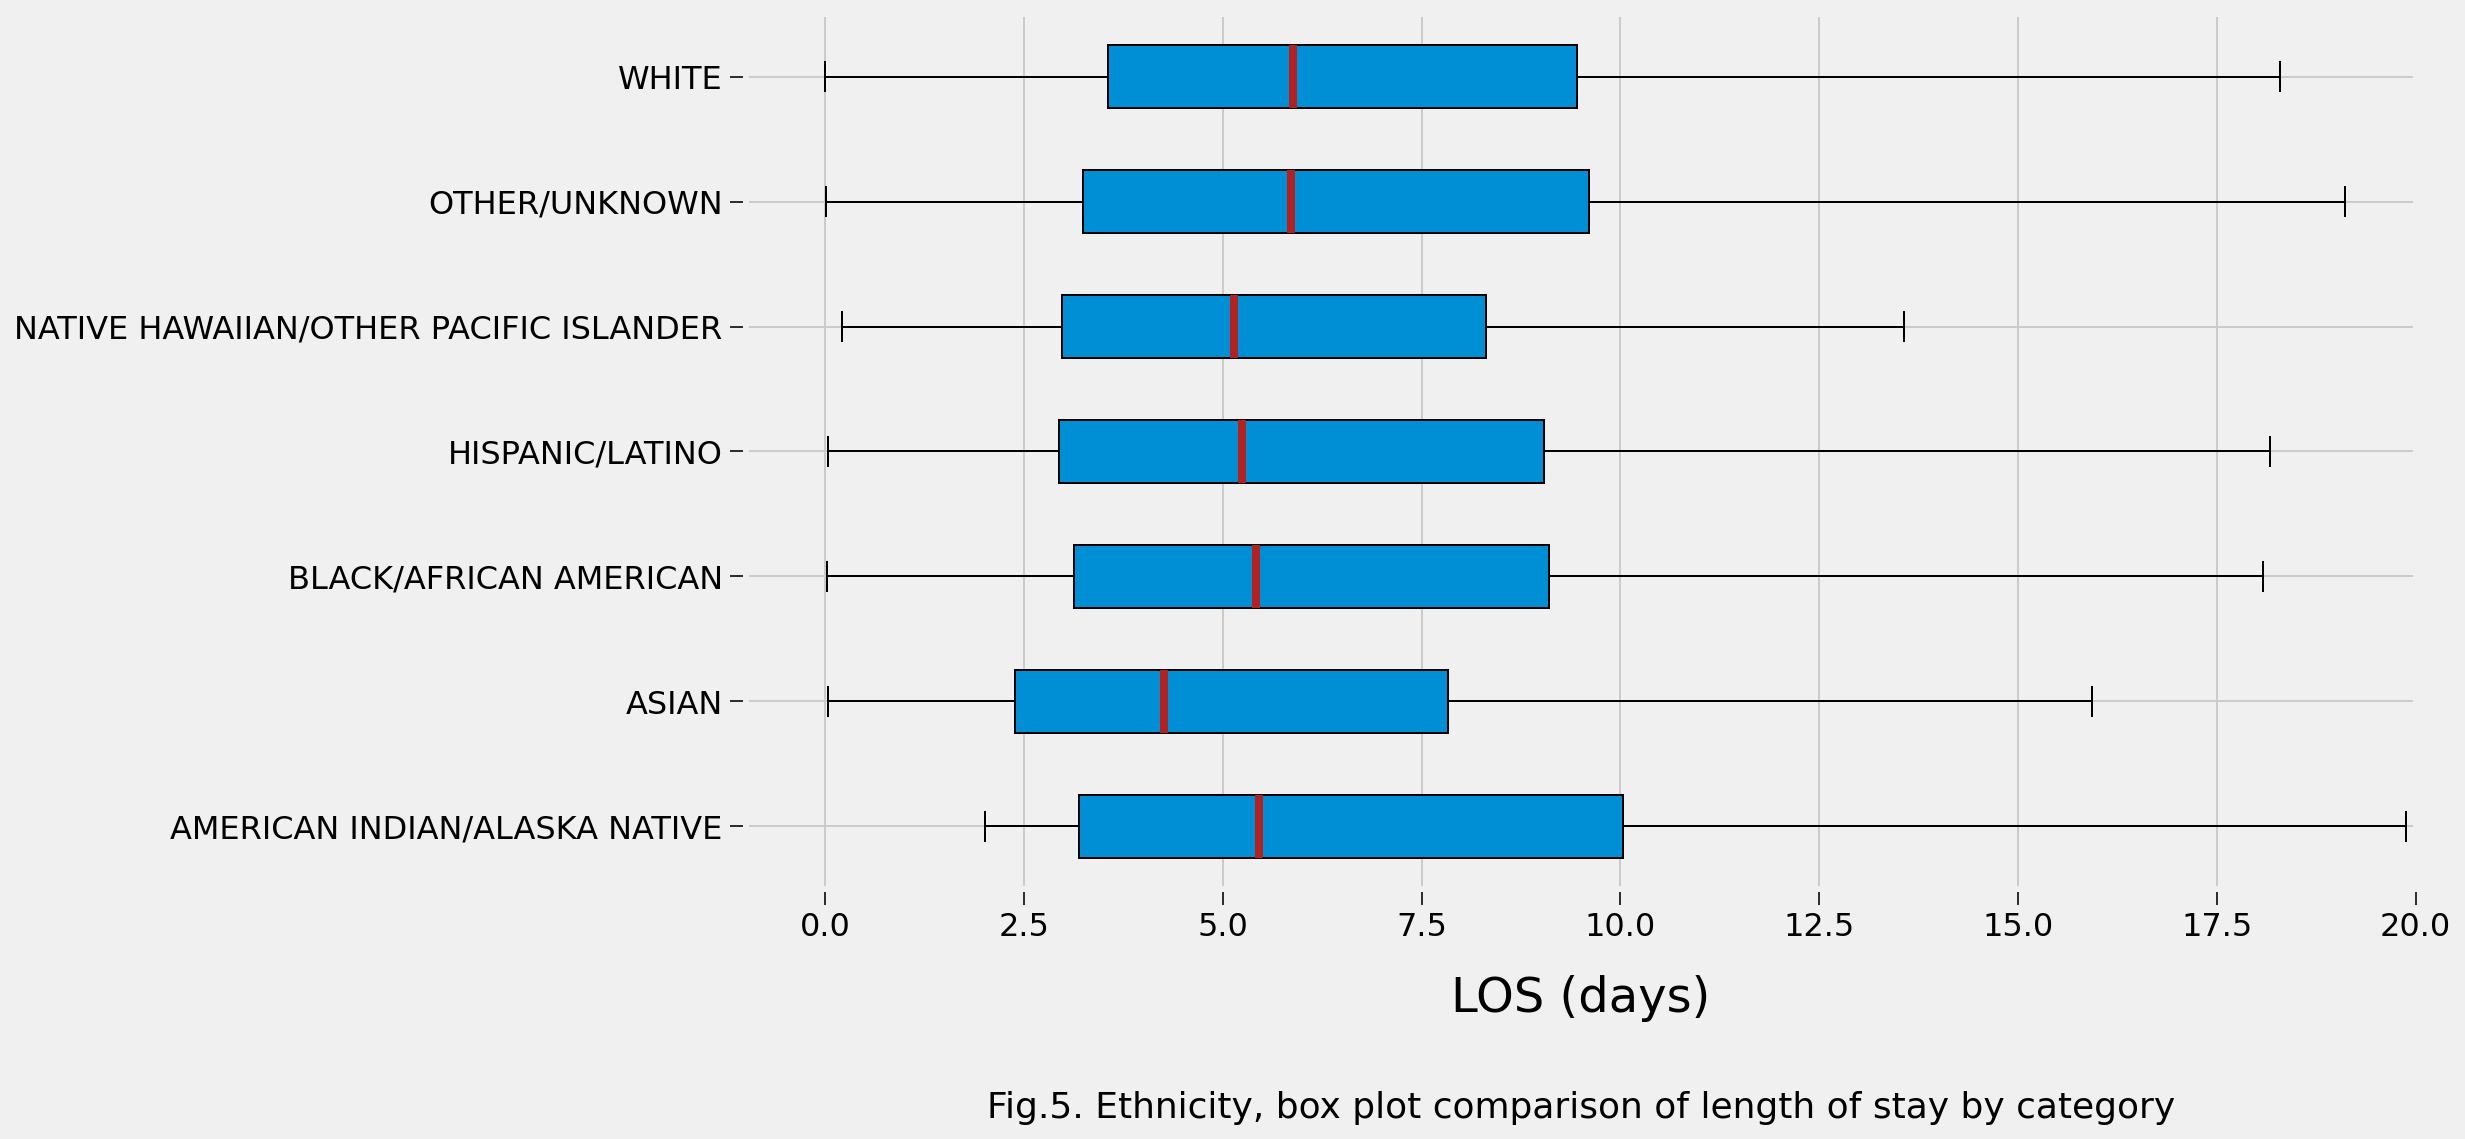

In [25]:
# Look at boxplot and median LOS for groups
fignum += 1 # add figure number to caption
boxplot_los_groupby('ETHNICITY', fignum, los_range=(-1, 20))

<a class="anchor" id="religion"></a>
### 2.1.3 Religion
The aim for this column is to better identify religious patients from patients who were less religious. In a [study](https://corporate.dukehealth.org/news-listing/religious-elderly-have-shorter-hospital-stays-lower-health-care-costs-study-finds) of religion's impact on health care costs, researchers found that patients that attended religious services once a week or more were 43% less likely to have been hospitalized in the previous year than people who never attended or only went a few times a year. 

In [26]:
df_adm['RELIGION'].value_counts()

CATHOLIC                  18135
NOT SPECIFIED             10595
UNOBTAINABLE               7245
PROTESTANT QUAKER          6291
JEWISH                     4810
OTHER                      2370
EPISCOPALIAN                682
GREEK ORTHODOX              403
CHRISTIAN SCIENTIST         377
BUDDHIST                    245
MUSLIM                      192
JEHOVAH'S WITNESS           120
UNITARIAN-UNIVERSALIST      112
HINDU                       101
ROMANIAN EAST. ORTH          70
7TH DAY ADVENTIST            68
BAPTIST                      24
HEBREW                       15
METHODIST                     5
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [ ]:
# Reduce categories to terms of being religious or not
df_adm['RELIGION'].loc[~df_adm['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(df_adm['RELIGION'].value_counts())
print(df_adm['RELIGION'].value_counts()[0]/len(df_adm['RELIGION']))
print(df_adm['RELIGION'].value_counts()[1]/len(df_adm['RELIGION']))
print(df_adm['RELIGION'].value_counts()[2]/len(df_adm['RELIGION']))

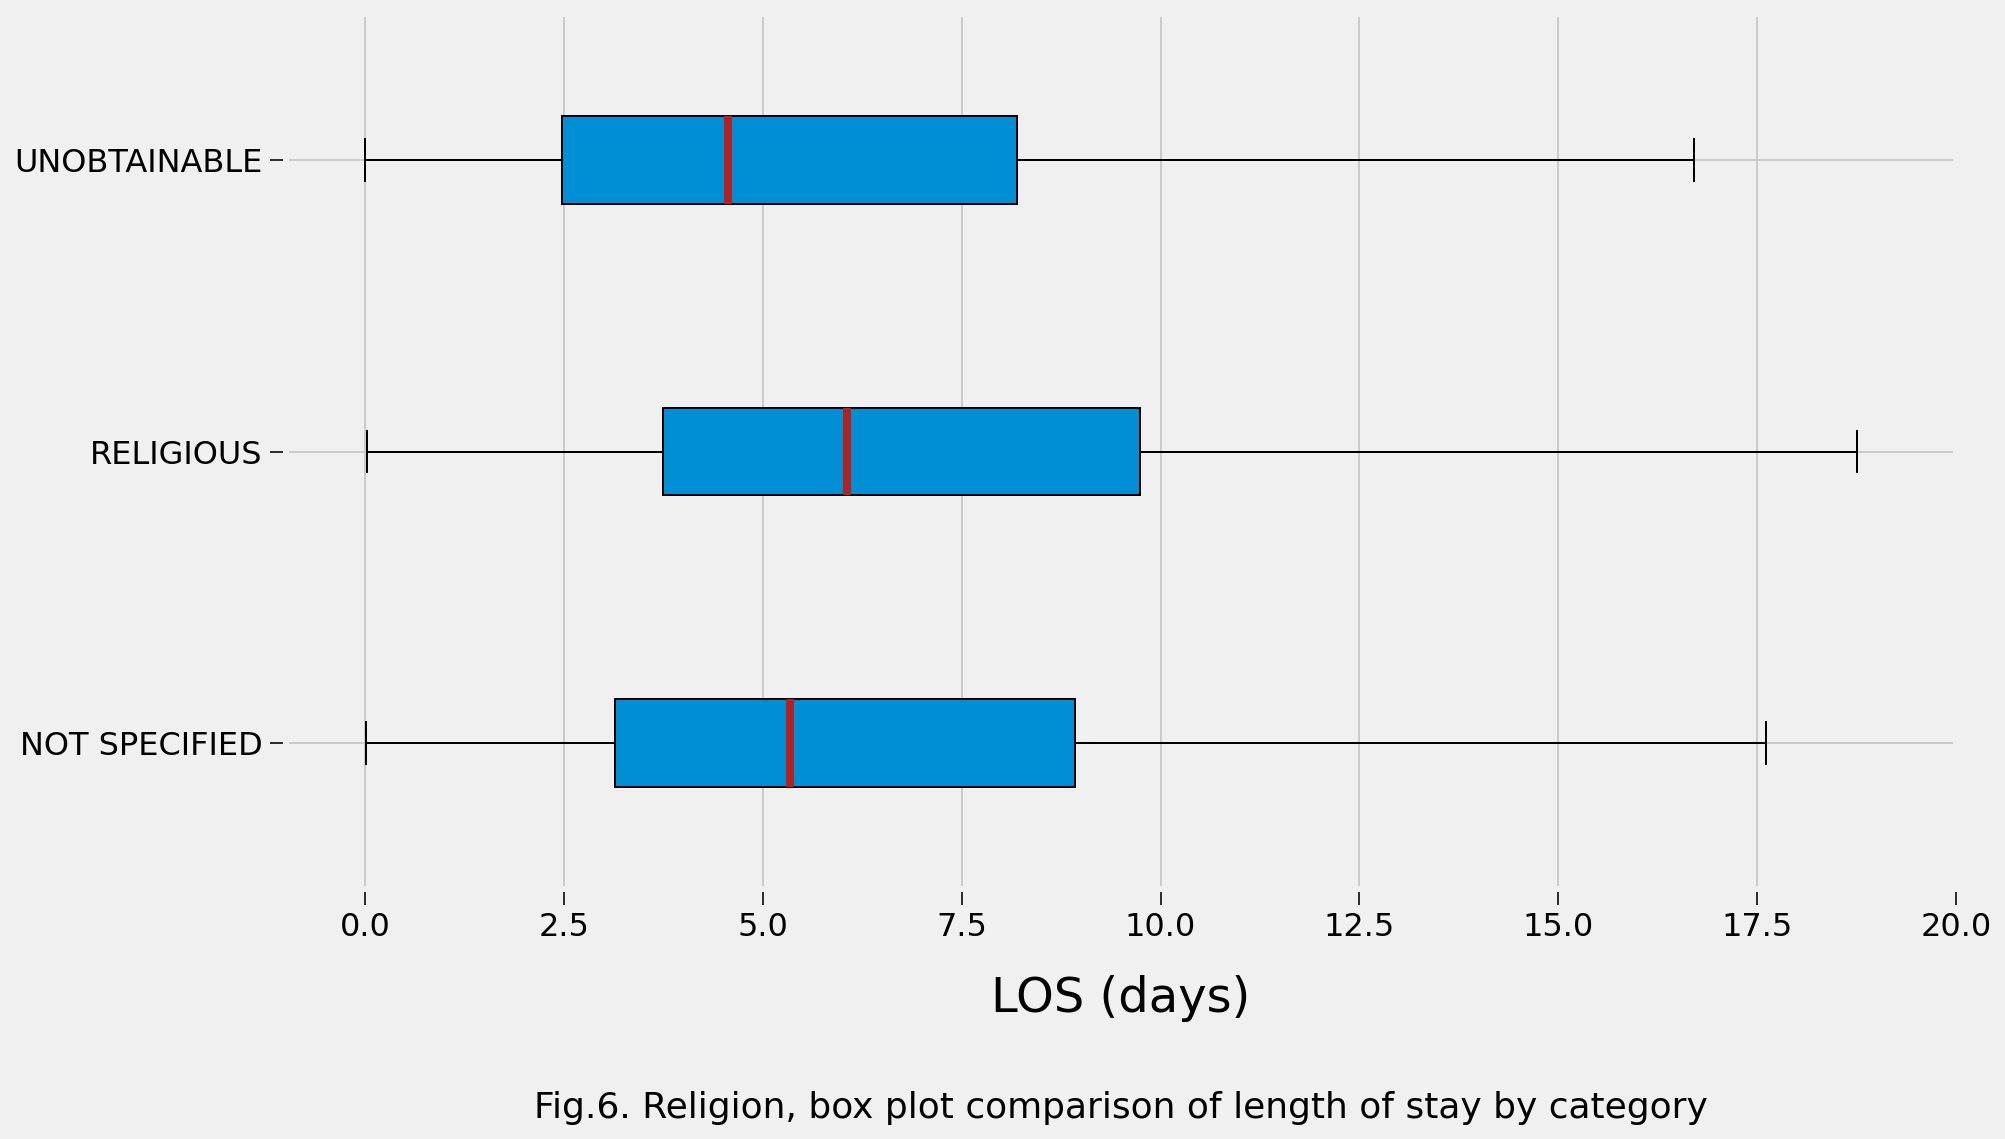

In [28]:
# Look at boxplot and median LOS for groups
fignum += 1 # add figure number to caption
boxplot_los_groupby('RELIGION', fignum, los_range=(-1, 20))

<a class="anchor" id="admin_type"></a>
### 2.1.4 Admission Type

Admissions for labor and delivery services (i.e. NEWBORNS) have the lowest median LOS. The second lowest median LOS is admissions for elective procedures (i.e. ELECTIVE). The results of this exploration are expected since both of these types of admissions often involve more upfront planning and relatively known risks to patients. 

In [29]:
df_adm['ADMISSION_TYPE'].value_counts()

EMERGENCY    37290
ELECTIVE      7152
NEWBORN       6710
URGENT        1108
Name: ADMISSION_TYPE, dtype: int64

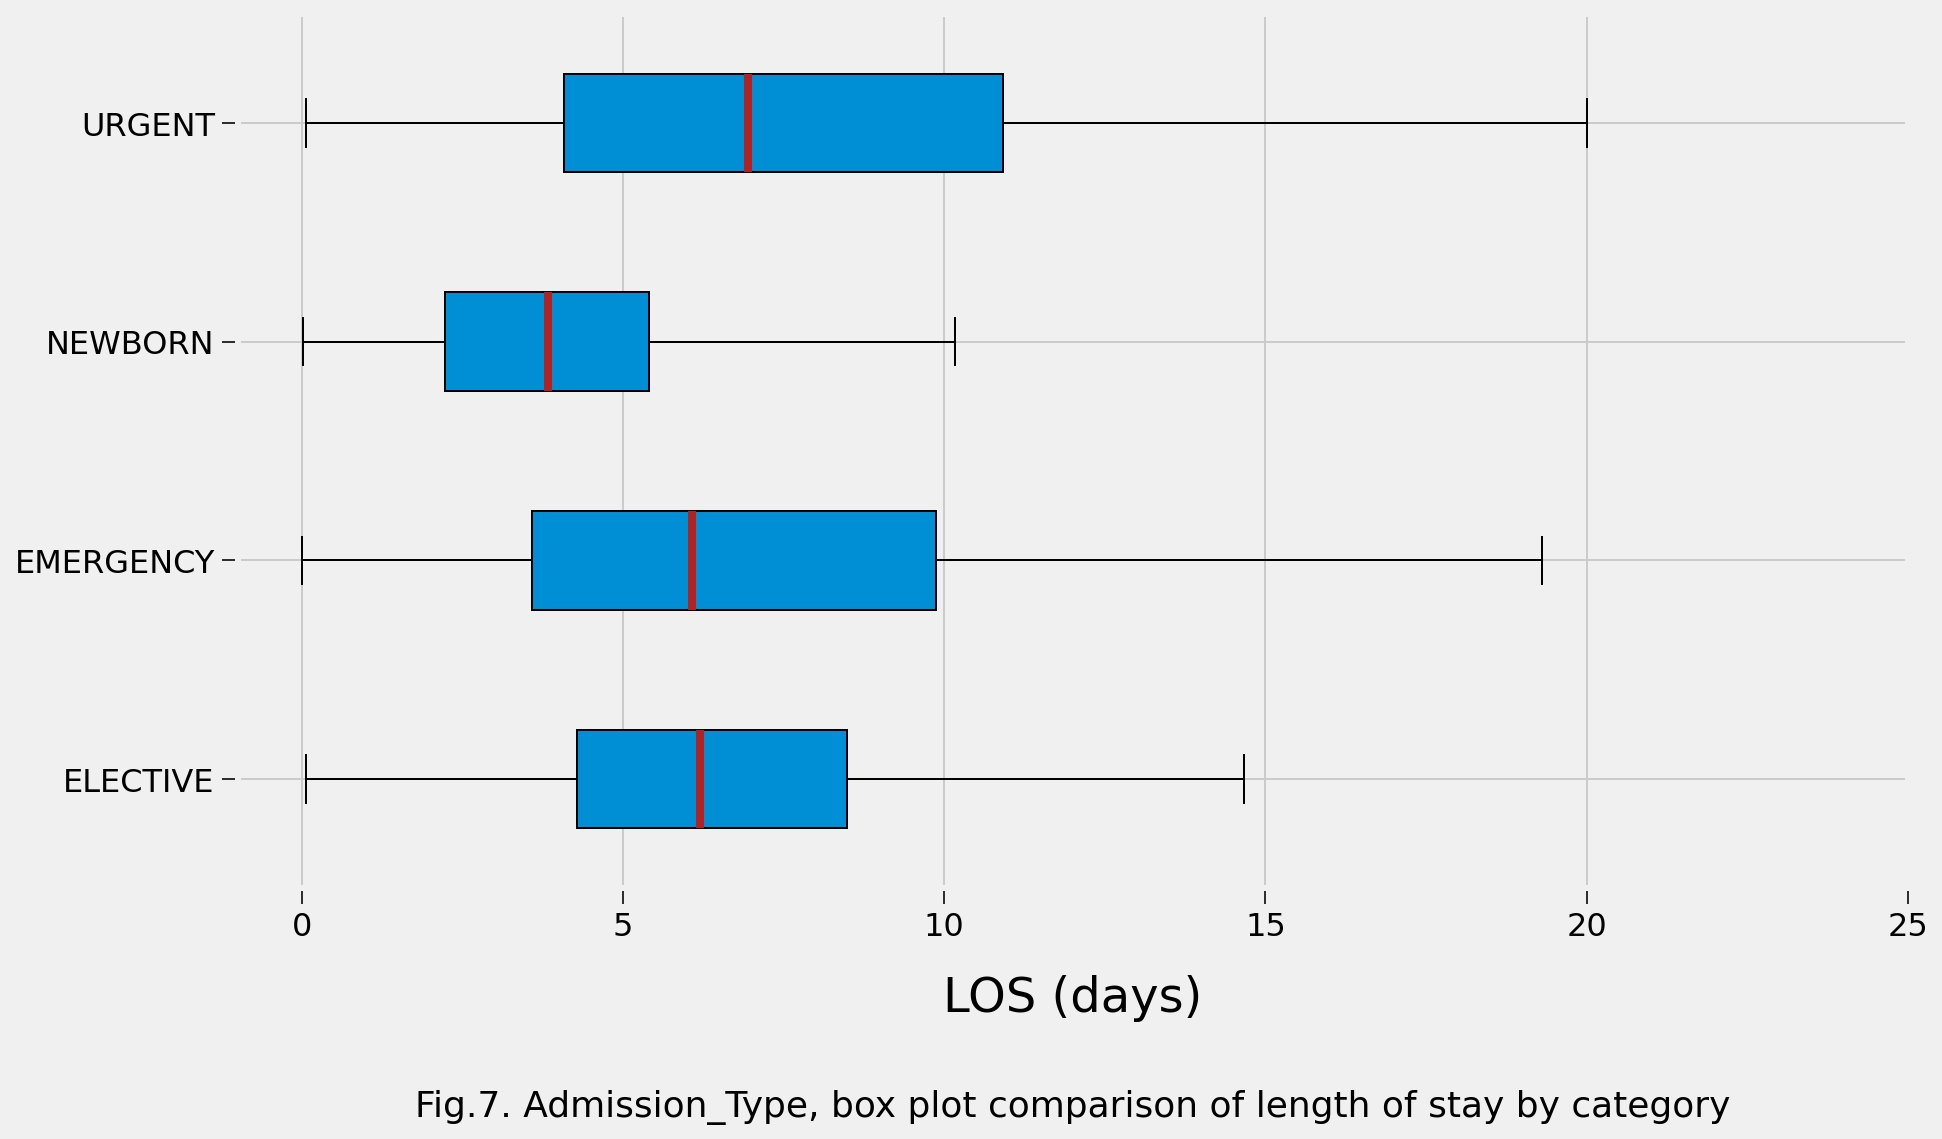

In [30]:
# Look at boxplot and median LOS for groups
fignum += 1 # add figure number to caption
boxplot_los_groupby('ADMISSION_TYPE', fignum, los_range=(-1, 25))

<a class="anchor" id="insurance"></a>
### 2.1.5 Insurance

Medicare is the federal government program that provides health care coverage (health insurance) if you are over 65, under 65 and receiving Social Security Disability Insurance for a certain amount of time, or under 65 and with End-Stage Renal Disease. The term 'Private' health insurance simply refers to any health insurance coverage that is not offered by a state or federal government. Instead, private health insurance is offered by a private entity, such as an insurance company or broker. Medicaid is the federal public health insurance program that provides health care coverage to low-income families or individuals. The term 'Government' health insurance includes other government health care programs such as the State Children's Health Insurance Program and Veterans Health Administration. The term 'Self-Pay' health insurance typically indicates the patient needed to pay out of pocket (or did not pay). Self-pay patients had the lowest LOS, which may also be an indication of poor quality care in this case.  

In [31]:
df_adm['INSURANCE'].value_counts()

Medicare      25312
Private       19874
Medicaid       4931
Government     1575
Self Pay        568
Name: INSURANCE, dtype: int64

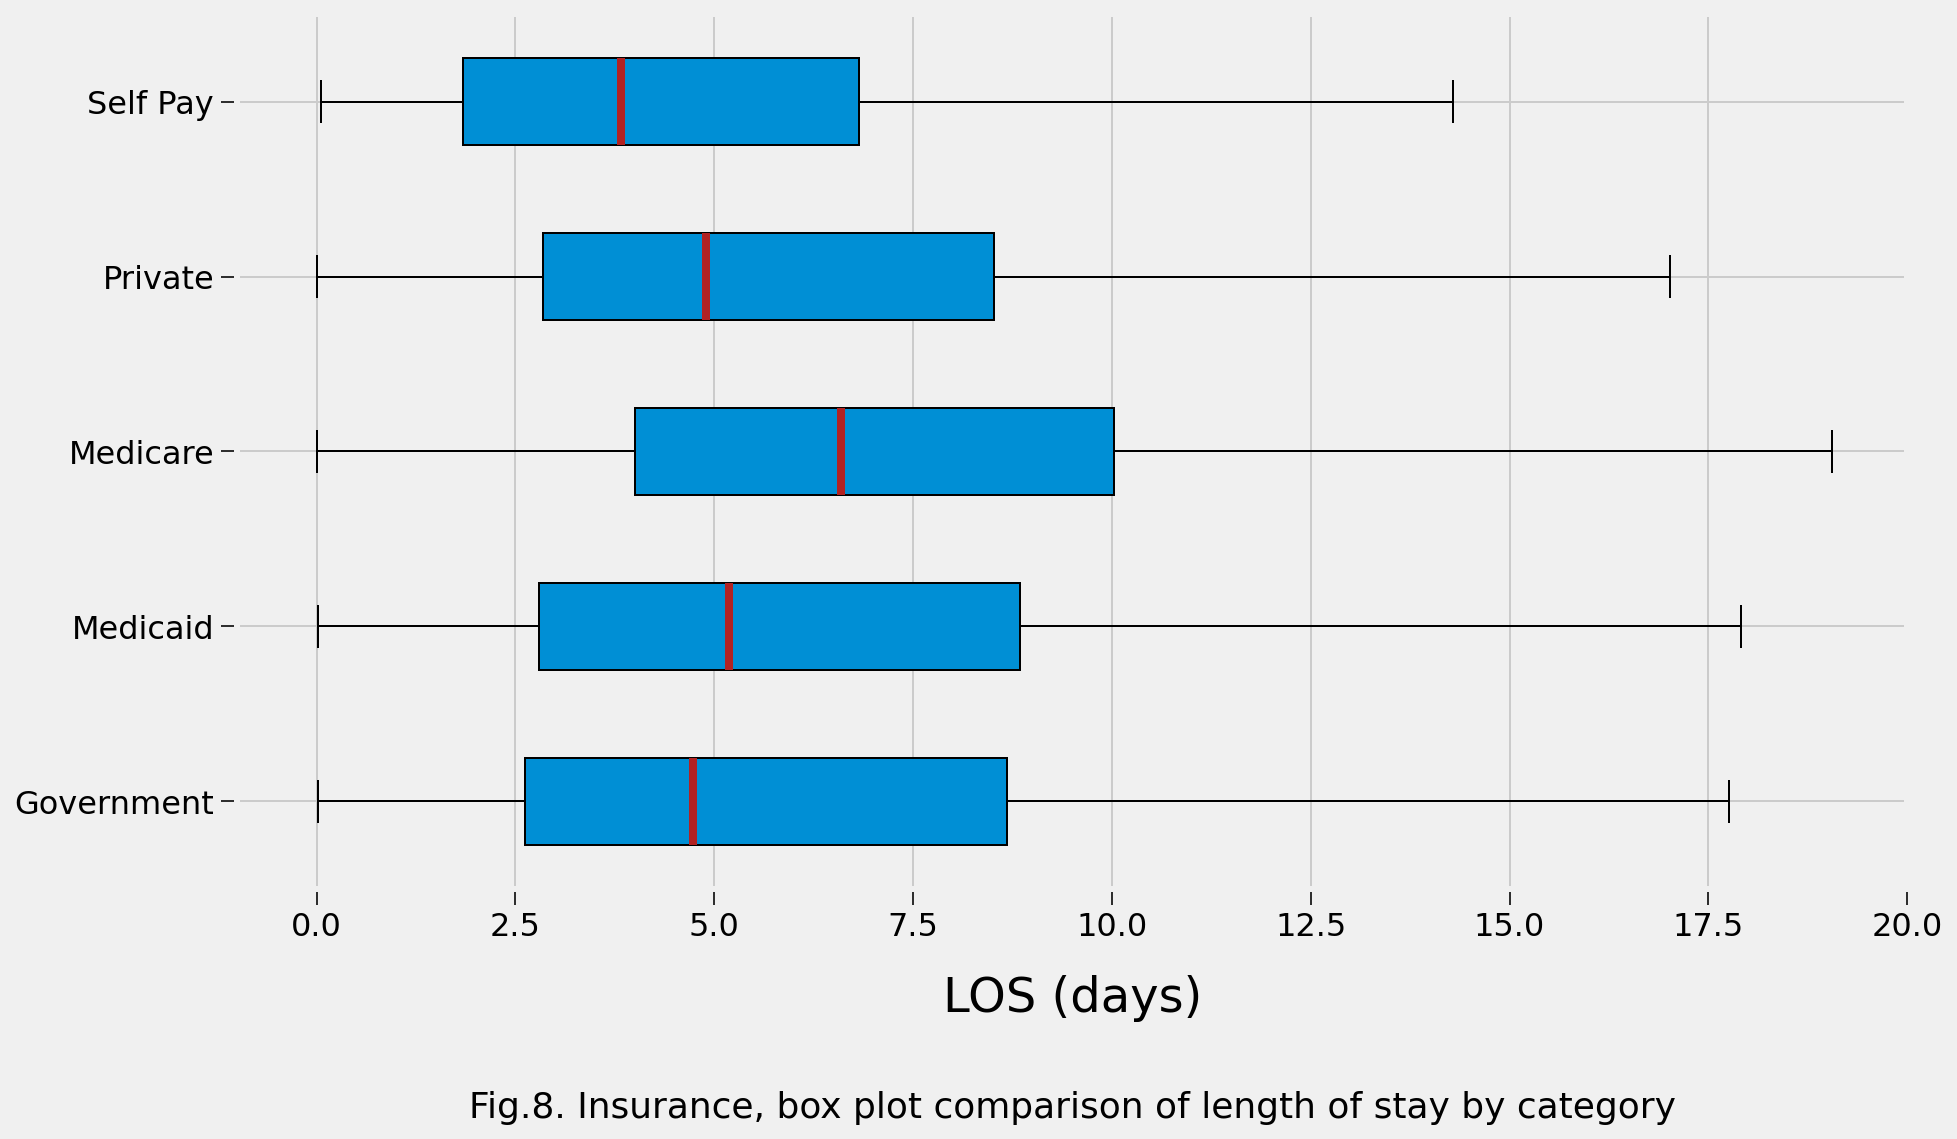

In [32]:
# Look at boxplot and median LOS for groups
fignum += 1 # add figure number to caption
boxplot_los_groupby('INSURANCE', fignum, los_range=(-1, 20))

<a class="anchor" id="marital"></a>
### 2.1.6 Marital status

The aim for this column was to better identify the marital status of patients admitted to the hospital. The primary action taken was assigning NaN values to the 'UNKNOWN' category. 

In [33]:
df_adm['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              21632
SINGLE               11727
NaN                   8700
WIDOWED               6564
DIVORCED              2823
SEPARATED              503
UNKNOWN (DEFAULT)      297
LIFE PARTNER            14
Name: MARITAL_STATUS, dtype: int64

In [34]:
# Fix NaNs and file under 'UNKNOWN'
df_adm['MARITAL_STATUS'] = df_adm['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df_adm['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              21632
SINGLE               11727
UNKNOWN (DEFAULT)     8997
WIDOWED               6564
DIVORCED              2823
SEPARATED              503
LIFE PARTNER            14
Name: MARITAL_STATUS, dtype: int64

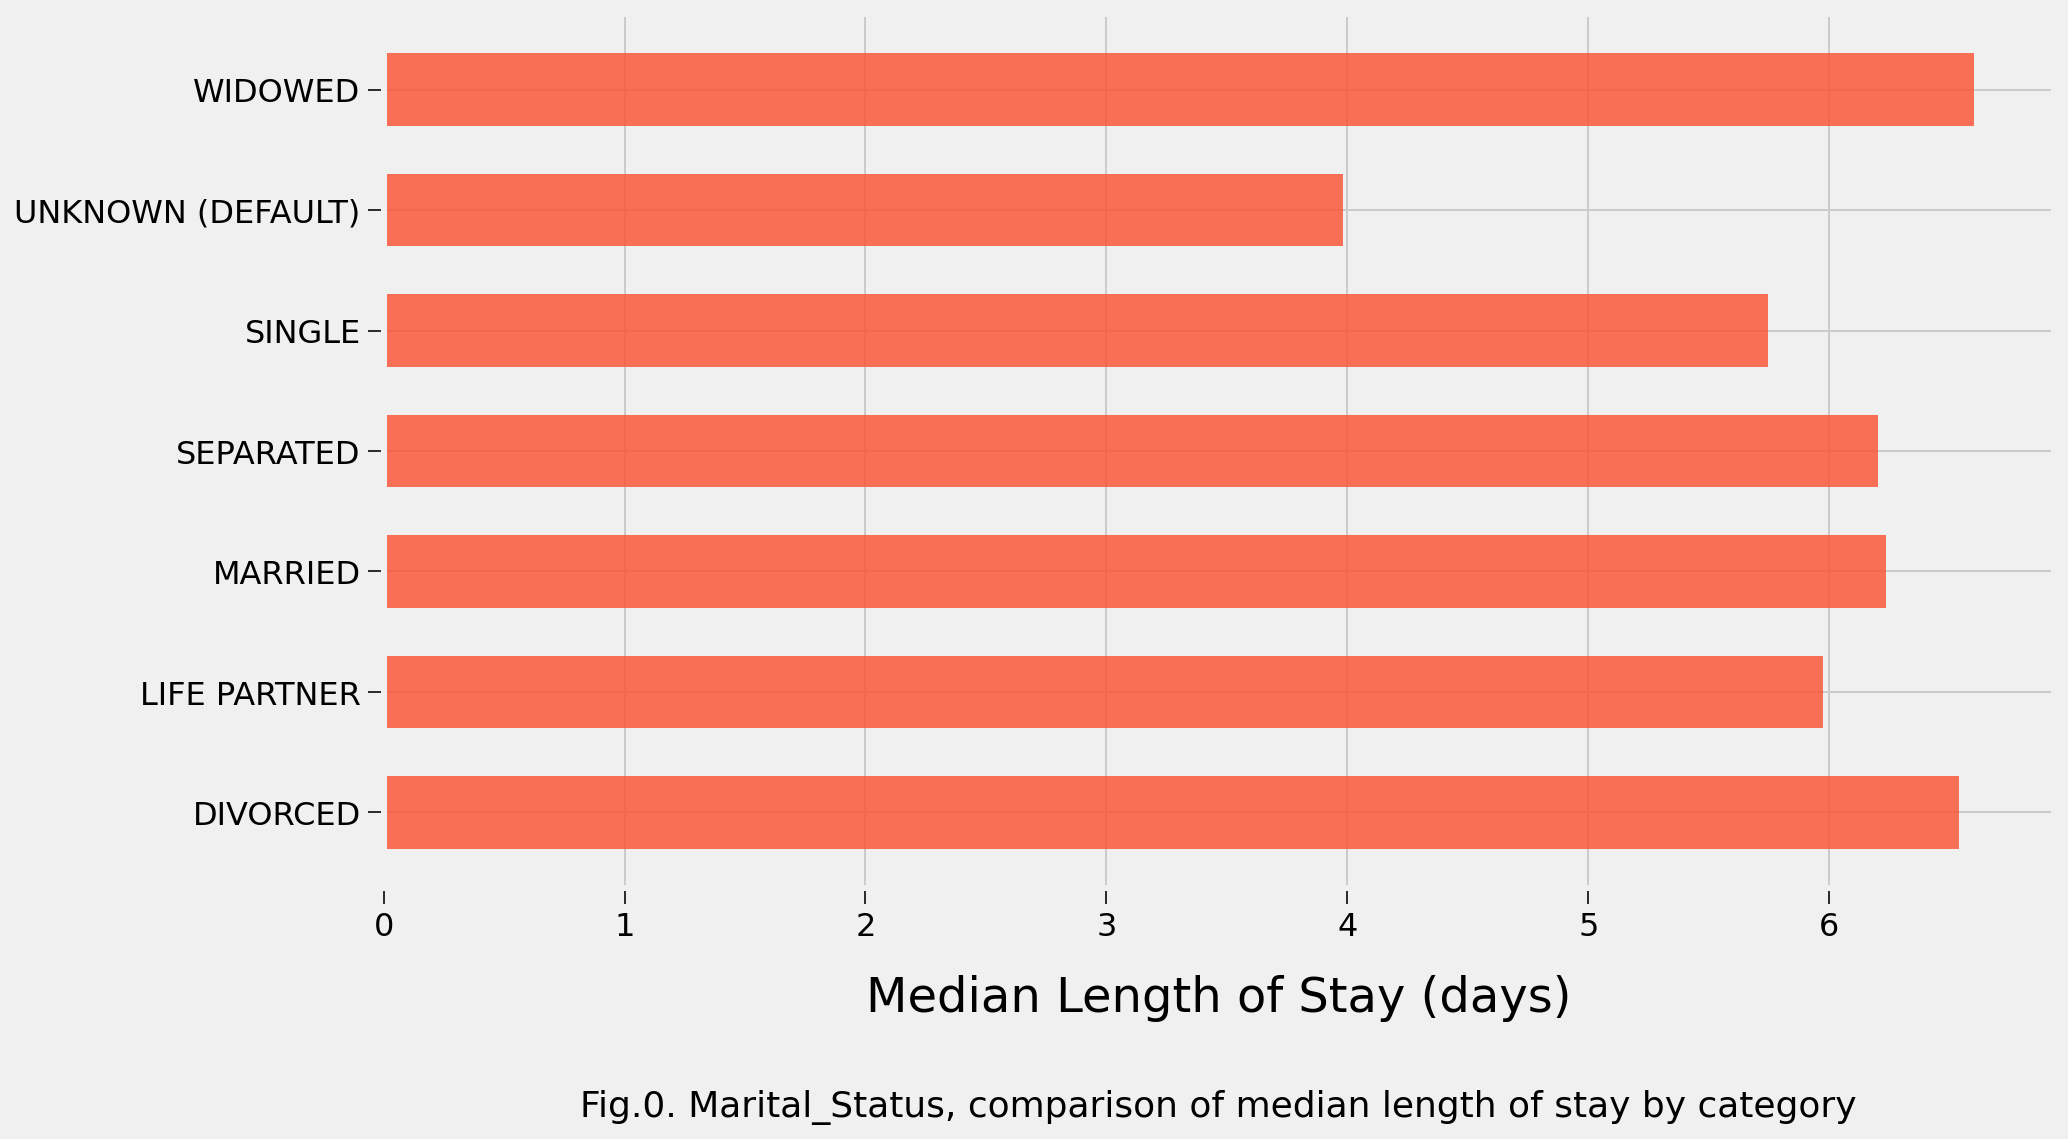

In [35]:
# Look at median LOS for groups
plot_los_groupby('MARITAL_STATUS')

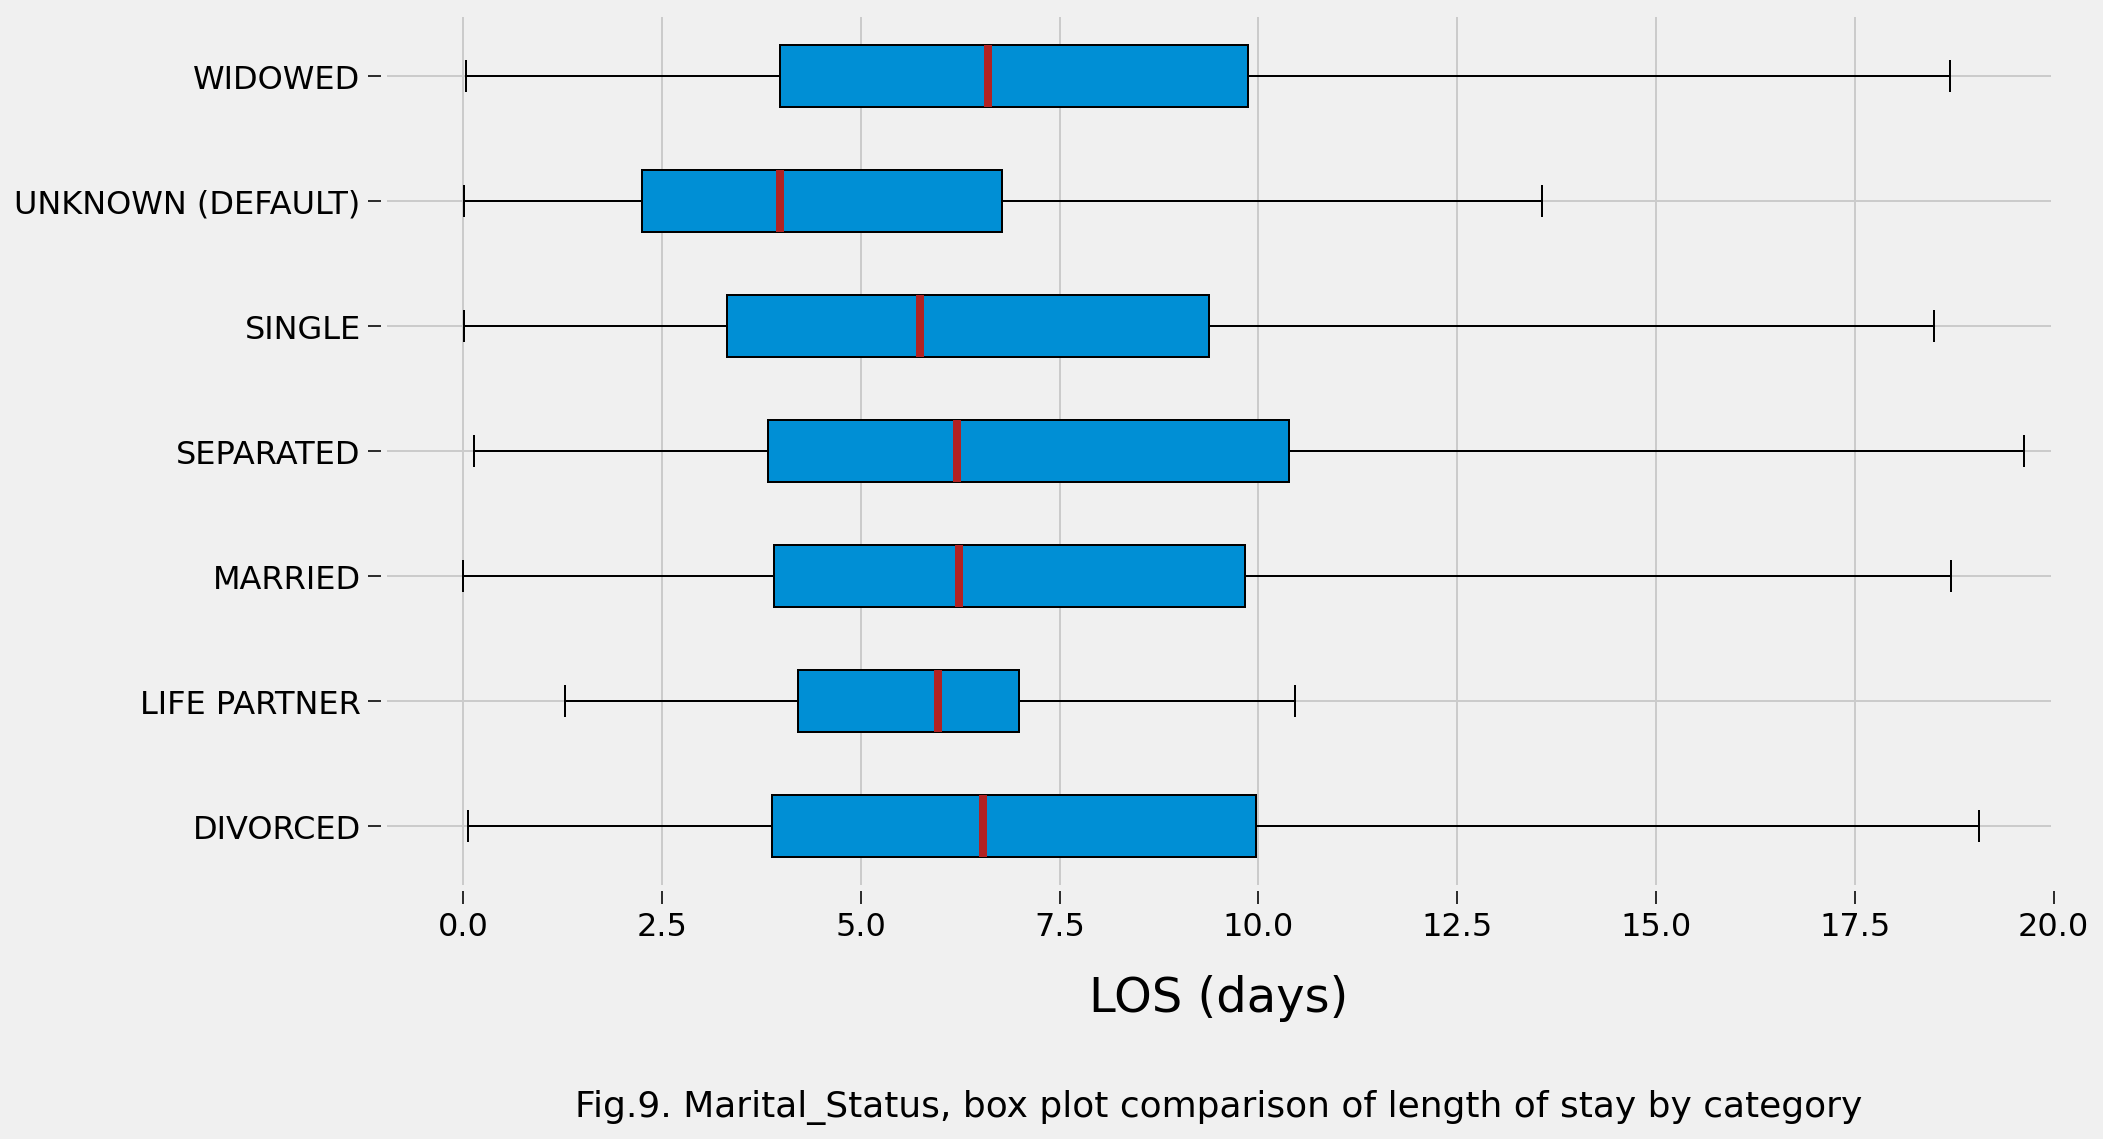

In [36]:
# Look at boxplot and median LOS for groups
fignum += 1 # add figure number to caption
boxplot_los_groupby('MARITAL_STATUS', fignum, los_range=(-1, 20))

<a class="anchor" id="diagnoses_icd"></a>
## 2.2 DIAGNOSES_ICD.csv Exploration 

This section explores the DIAGNOSES_ICD.csv table of the MIMIC-III database. The aim is to better summarize the existing categories with the list of codes for [International Statistical Classification of Diseases and Related Health Problems](https://en.wikipedia.org/wiki/List_of_ICD-9_codes). The International Classification of Diseases - Ninth Revision (ICD-9) was used in assigning diagnostic and procedure codes associated with inpatient, outpatient, and physician office utilization in the United States. 

In [37]:
df_dig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [38]:
print('There are {} unique ICD9 codes in this dataset.'.format(df_dig['ICD9_CODE'].value_counts().count()))

There are 6984 unique ICD9 codes in this dataset.


In [39]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_dig['recode'] = df_dig['ICD9_CODE']
df_dig['recode'] = df_dig['recode'][~df_dig['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_dig['recode'].fillna(value='999', inplace=True)

df_dig['recode'] = df_dig['recode'].str.slice(start=0, stop=3, step=1)
df_dig['recode'] = df_dig['recode'].astype(int)

In [40]:
# Create ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Create associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Update the codes in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_dig['recode'] = np.where(df_dig['recode'].between(cat_range[0],cat_range[1]), 
            num, df_dig['recode'])
    
# Convert integer to category name using diag_dict
df_dig['recode'] = df_dig['recode']
df_dig['cat'] = df_dig['recode'].replace(diag_dict)

In [41]:
# Verify the feature engineering was done correctly
df_dig.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode,cat
0,1297,109,172335,1.0,40301,6,circulatory
1,1298,109,172335,2.0,486,7,respiratory
2,1299,109,172335,3.0,58281,9,genitourinary
3,1300,109,172335,4.0,5855,9,genitourinary
4,1301,109,172335,5.0,4254,6,circulatory


For each admission, there was often more than one diagnosis, and even more than 1 diagnoses for 1 category. A dummy matrix was needed to highlight all the diagnoses for each admission. The transformation was not done on the SUBJECT_ID since it was possible for each paitent to have different diagnoses for each admission. 

In [42]:
# Create list of diagnoses for each admission
hadm_list = df_dig.groupby('HADM_ID')['cat'].apply(list).reset_index()
hadm_list.head()

,HADM_ID,cat
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [43]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [44]:
# Join back with HADM_ID
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009


In [45]:
# Merge with main admissions df
df_adm = df_adm.merge(hadm_item, how='inner', on='HADM_ID')

# Verify merge was done correctly
df_adm.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,4,1,0,0,0,1,0,0,0,0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,1,0,0,0,0,1,0,0,0,0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,3,0,0,0,1,1,0,1,0,0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,0,0,0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,0,0,0


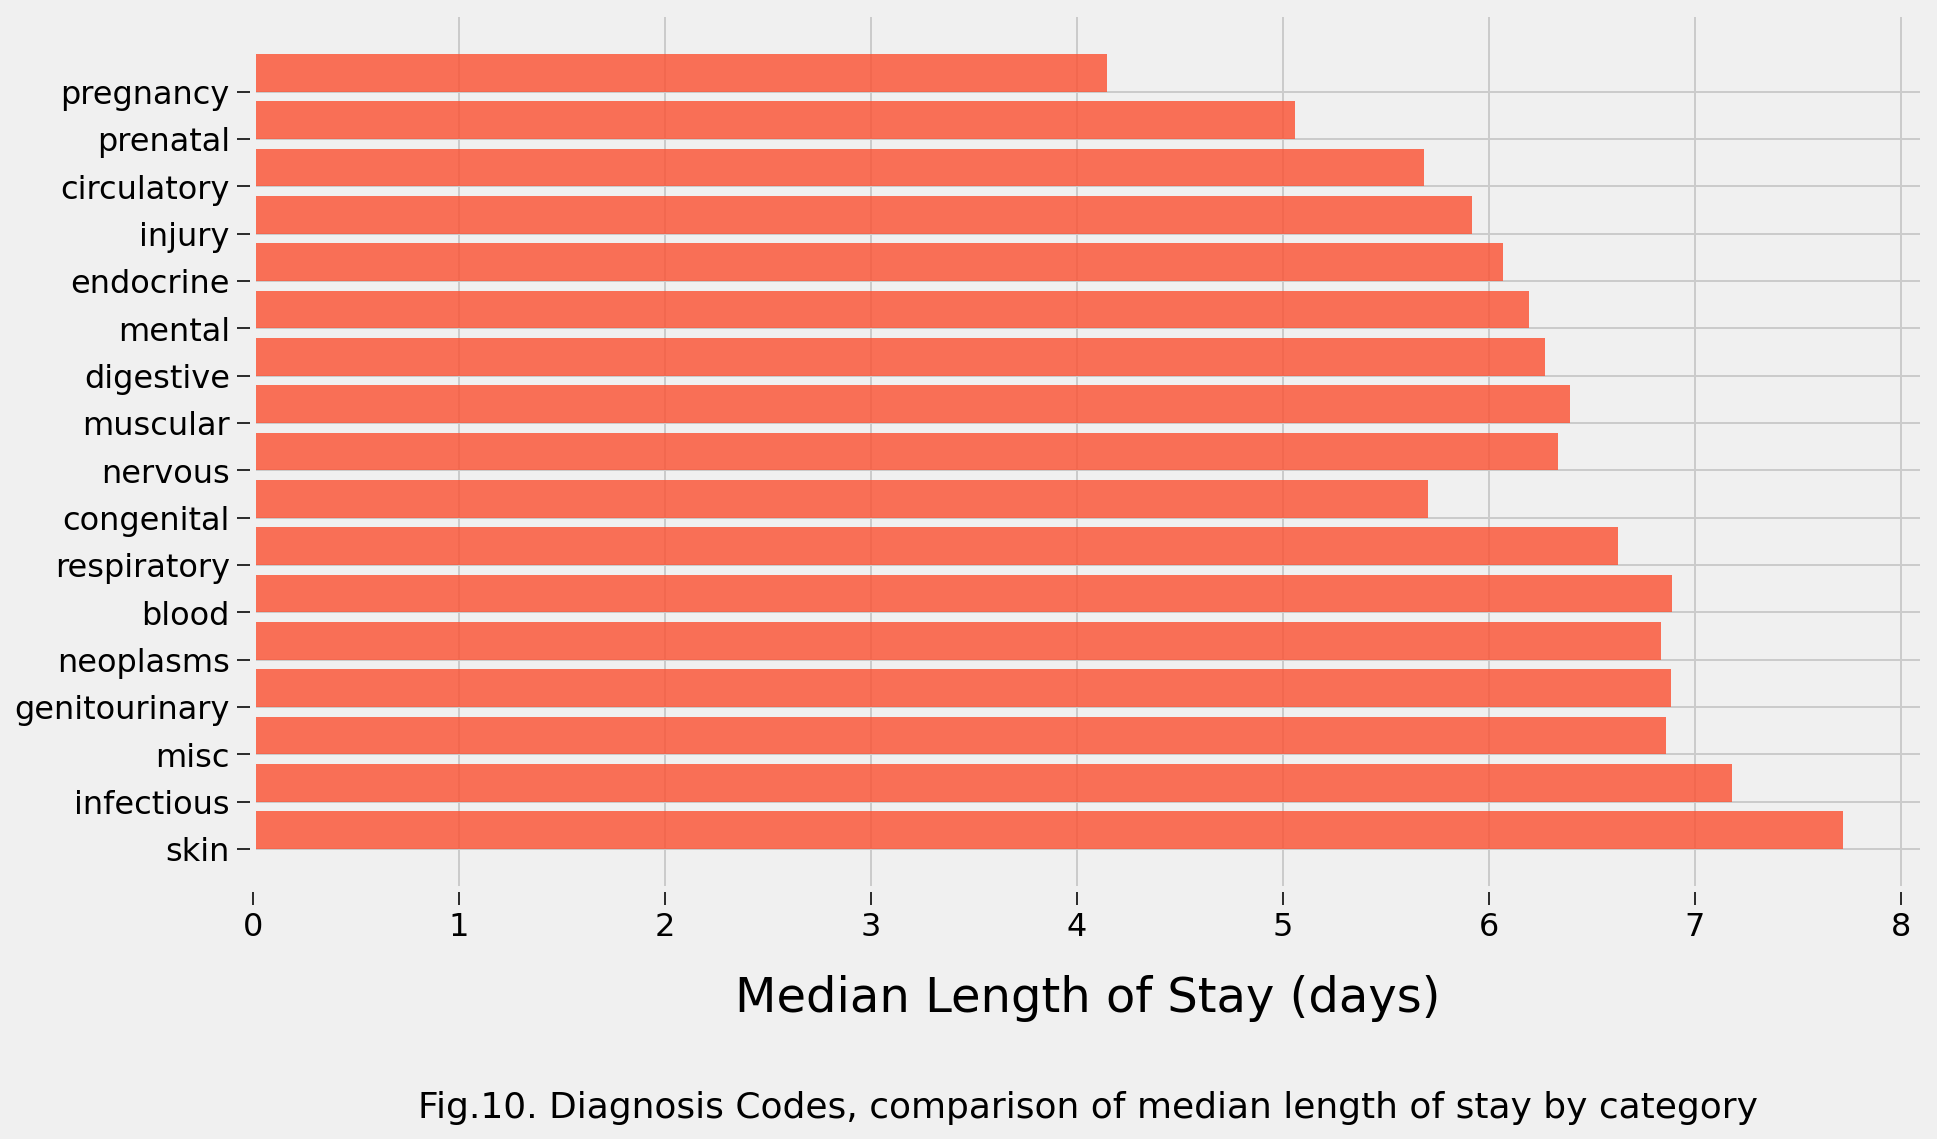

In [46]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df_adm[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

#sns.set(style="whitegrid")
#sns.set_style("ticks")
fig,ax = plt.subplots(figsize=(13.33, 7.5))
ind = range(len(results))
ax.barh(ind, results, align='edge', alpha=0.8, color='#fc4f30')
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)', size=24, labelpad=16)
ax.tick_params(axis='both', labelsize=16, length=8)

# Add caption
fignum += 1 
figtxt = '. ' + 'Diagnosis Codes' + ', comparison of median length of stay by category'
figcap = 'Fig.' + str(fignum) + figtxt
ax.text(0.5, -0.25, figcap, fontsize=18, ha='center', va='center', transform=ax.transAxes)
plt.savefig('fig' + str(fignum) + '-diagnosis-codes.png', bbox_inches='tight')

plt.show();

<a class="anchor" id="patients"></a>
## 2.3 PATIENTS.csv Exploration 

This section explores the PATIENTS.csv table of the MIMIC-III database. The PATIENTS table provided age and gender information. A patient’s age is given as the difference between their 'DOB' date of birth and the date of their first admission. Therefore, subsequent admissions for the same patient are ignored in the calculation. The primary action is to extract the DOB and gender information and merge them with the admissions dataframe. 

In [47]:
df_pat.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [48]:
df_pat['GENDER'].value_counts()

M    26121
F    20399
Name: GENDER, dtype: int64

In [49]:
# Convert date of birth to datetime type
df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])

In [50]:
df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
df_pat.head()

,SUBJECT_ID,DOB,GENDER
0,249,2075-03-13,F
1,250,2164-12-27,F
2,251,2090-03-15,M
3,252,2078-03-06,M
4,253,2089-11-26,F


In [51]:
# Merge with main admissions df
df_adm = df_adm.merge(df_pat, how='inner', on='SUBJECT_ID')

In [52]:
# Find the first admission time for each patient
df_age_min = df_adm[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df_age_min.head()

,SUBJECT_ID,ADMIT_MIN
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


In [53]:
# Merge with main admissions df
df_adm = df_adm.merge(df_age_min, how='outer', on='SUBJECT_ID')

df_adm.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,0,0,1,0,0,0,0,2131-05-07,F,2196-04-09 12:26:00
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,0,0,1,0,0,0,0,2082-07-17,M,2153-09-03 07:15:00
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,0,1,1,0,1,0,0,2082-07-17,M,2153-09-03 07:15:00
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,2100-05-31,M,2139-06-06 16:14:00
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,2101-11-21,M,2160-11-02 02:06:00


In [54]:
df_adm.dtypes

SUBJECT_ID                     int64
HADM_ID                        int64
ADMITTIME             datetime64[ns]
DEATHTIME                     object
ADMISSION_TYPE                object
ADMISSION_LOCATION            object
DISCHARGE_LOCATION            object
INSURANCE                     object
LANGUAGE                      object
RELIGION                      object
MARITAL_STATUS                object
ETHNICITY                     object
DIAGNOSIS                     object
LOS                          float64
DECEASED                       int64
LOS_SHORT                    float64
blood                          uint8
circulatory                    uint8
congenital                     uint8
digestive                      uint8
endocrine                      uint8
genitourinary                  uint8
infectious                     uint8
injury                         uint8
mental                         uint8
misc                           uint8
muscular                       uint8
n

In [55]:
# Decode Age by finding the difference in admission date and date of birth
df_adm['ADMIT_MIN'] = pd.to_datetime(df_adm['ADMIT_MIN']).dt.date
df_adm['DOB'] = pd.to_datetime(df_adm['DOB']).dt.date

# Calculate age element per element, since calculation unable to convert a timedelta64[ns] datatype
df_adm['age'] = df_adm.apply(lambda x: (x['ADMIT_MIN'] - x['DOB']).days//365, axis=1)
df_adm['age'] = np.where(df_adm['age'] > 100, 90, df_adm['age'])
df_adm['age'].isnull().sum()

0

In [56]:
df_adm['age'].describe()

count    52260.000000
mean        54.872101
std         26.890925
min          0.000000
25%         43.000000
50%         61.000000
75%         75.000000
max         90.000000
Name: age, dtype: float64

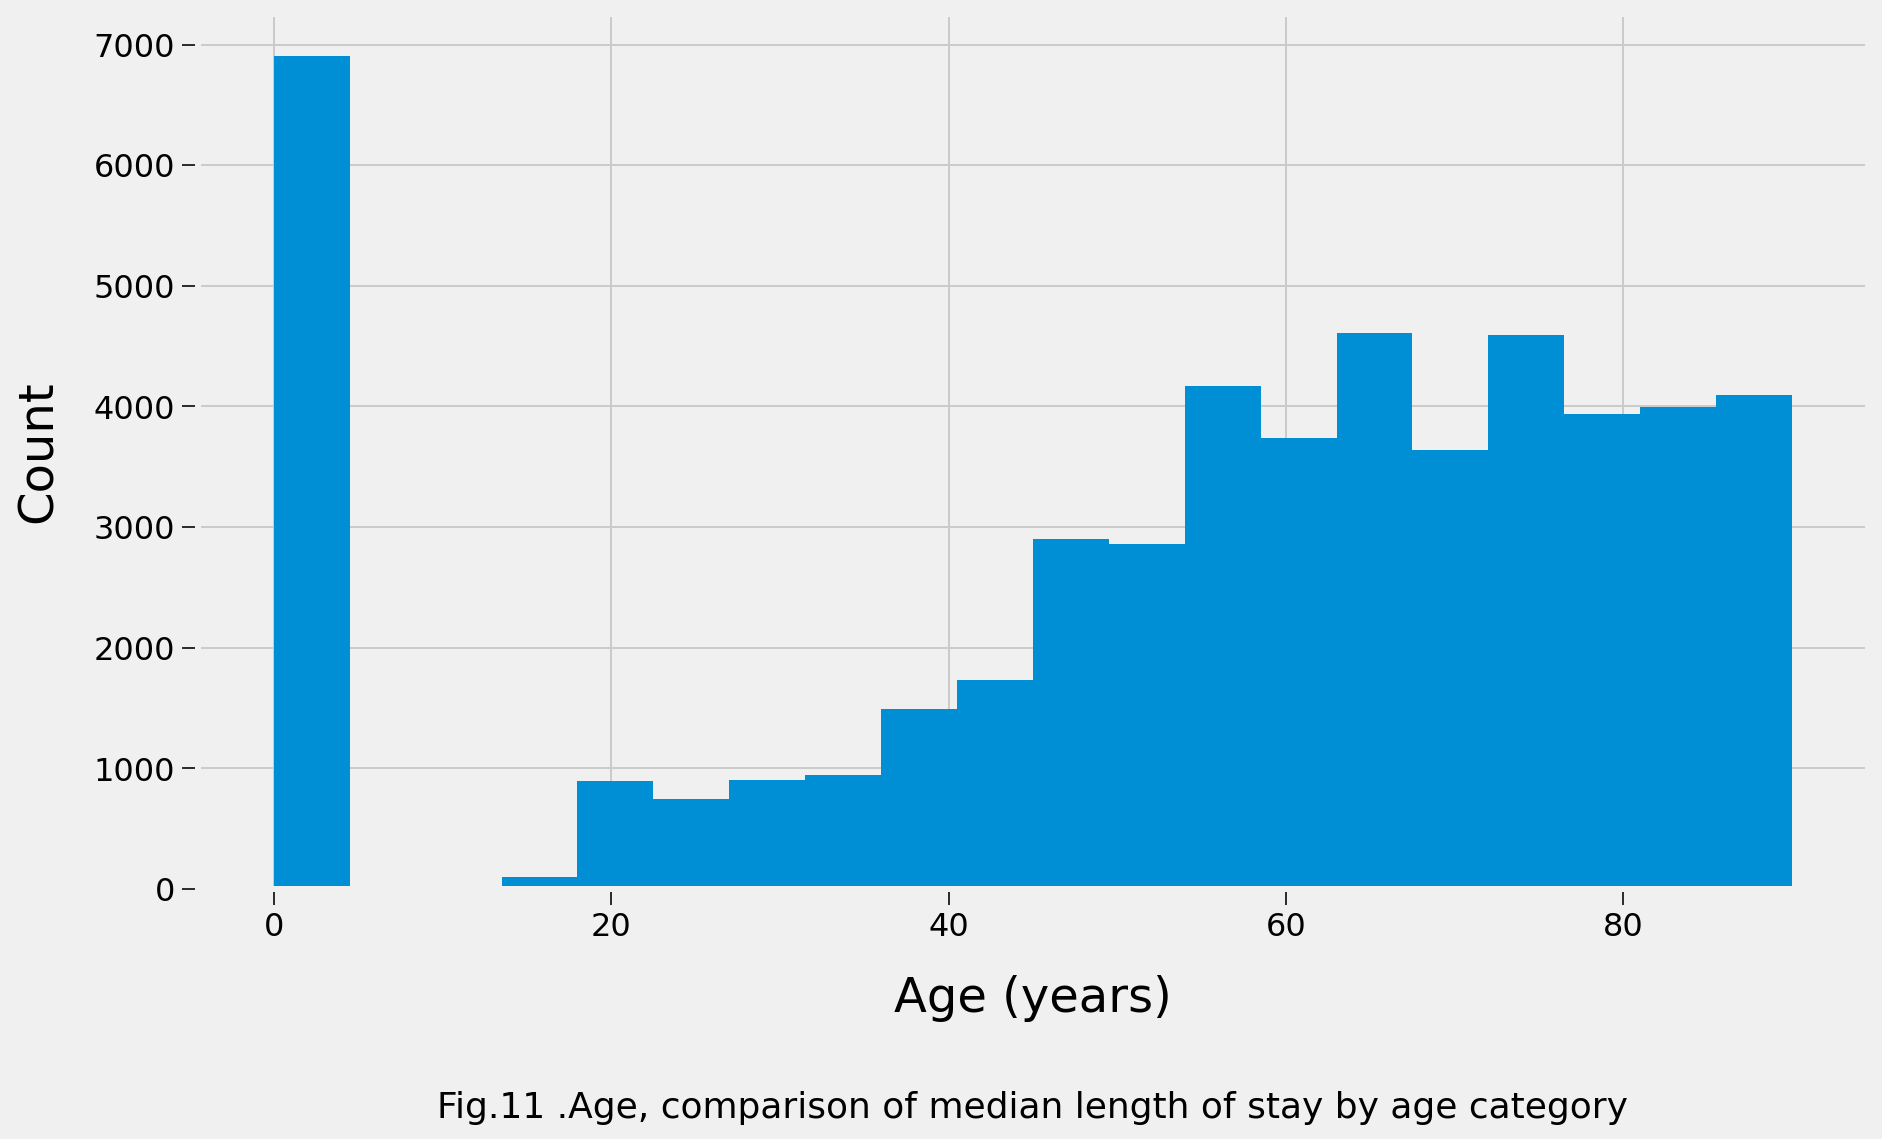

In [57]:
# Plot distribution of Age
fig,ax = plt.subplots(figsize=(13.33, 7.5))
ax.hist(df_adm['age'], bins=20)
ax.set_ylabel('Count', size=24, labelpad=16)
ax.set_xlabel('Age (years)', size=24, labelpad=16)
ax.tick_params(axis='both', labelsize=16, length=8)

# Add caption
fignum += 1
figtxt = ' .' + 'Age' + ', comparison of median length of stay by age category'
figcap = 'Fig.' + str(fignum) + figtxt
ax.text(0.5, -0.25, figcap, fontsize=18, ha='center', va='center', transform=ax.transAxes)
plt.savefig('fig' + str(fignum) + '-' + 'age' + 
            '-distribtion.png', bbox_inches='tight')

plt.show();

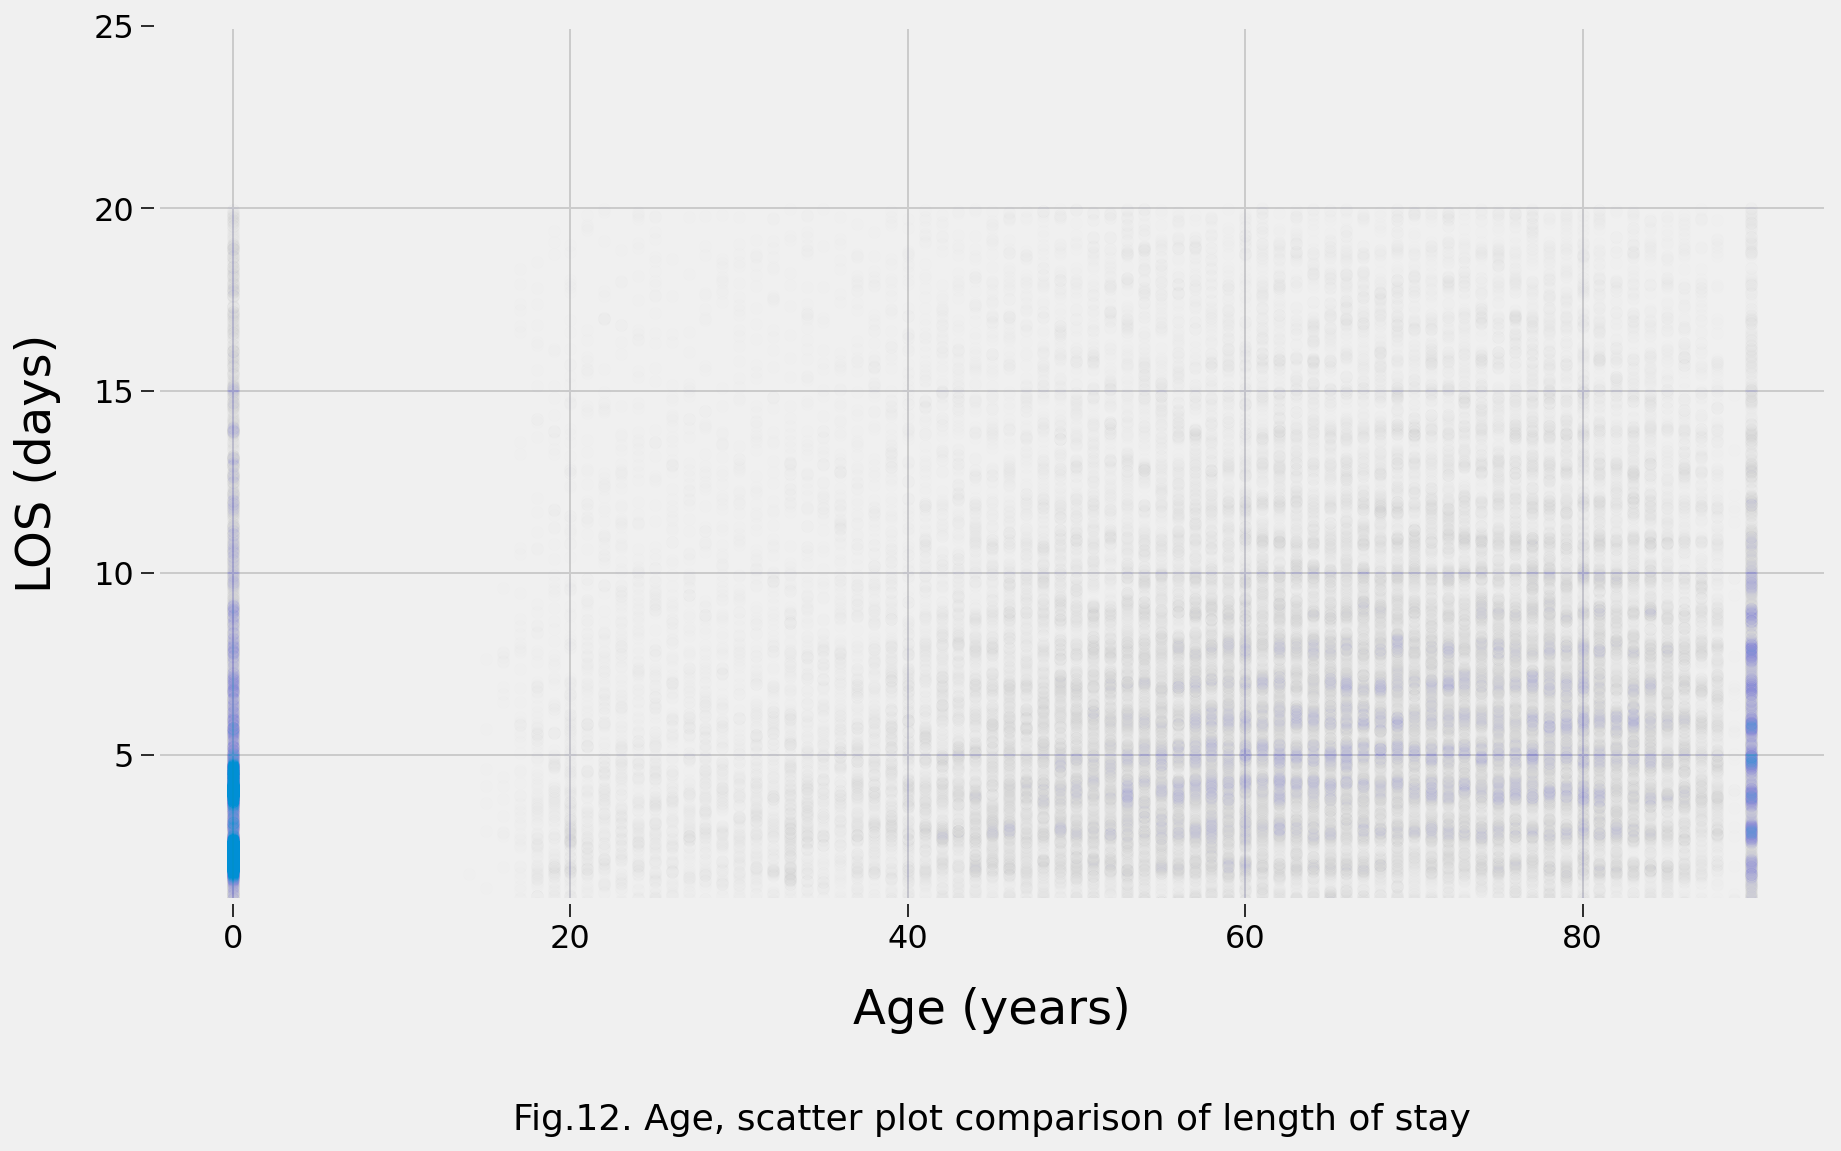

In [58]:
fig,ax = plt.subplots(figsize=(13.33, 7.5))
ax.scatter(df_adm['age'], df_adm['LOS'], alpha=0.005)
ax.set_ylabel('LOS (days)', size=24, labelpad=16)
ax.set_xlabel('Age (years)', size=24, labelpad=16)
ax.set_ylim(1, 25)
ax.tick_params(axis='both', labelsize=16, length=8) 

# Add caption
fignum += 1
figtxt = '. ' + 'Age' + ', scatter plot comparison of length of stay'
figcap = 'Fig.' + str(fignum) + figtxt
ax.text(0.5, -0.25, figcap, fontsize=18, ha='center', va='center', transform=ax.transAxes)
plt.savefig('fig' + str(fignum) + '-age' + 
            '-scatter-plot.png', bbox_inches='tight')

plt.show();

In [59]:
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    df_adm['age'] = np.where(df_adm['age'].between(cat_range[0],cat_range[1]), 
            num, df_adm['age'])
    
age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
df_adm['age'] = df_adm['age'].replace(age_dict)
df_adm.age.value_counts()

senior          30406
middle_adult    11135
newborn          6907
young_adult      3812
Name: age, dtype: int64

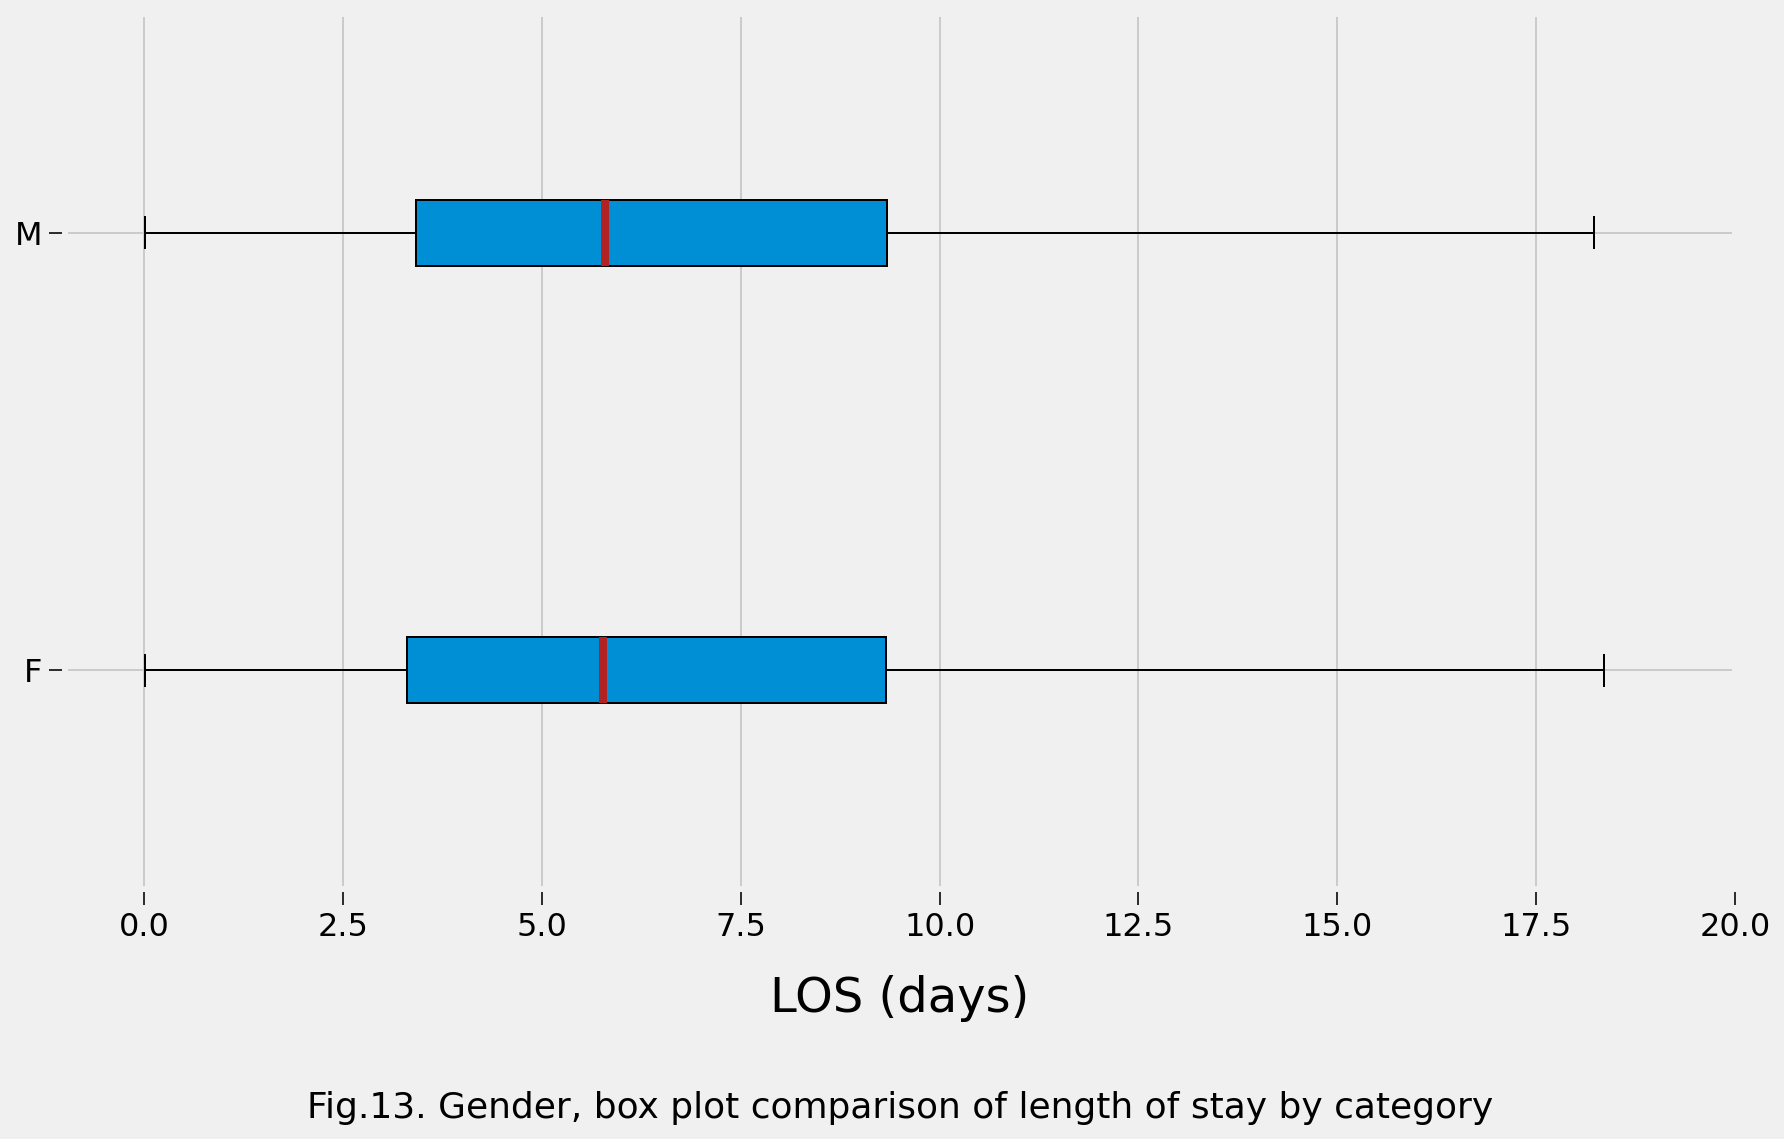

In [60]:
# Look at boxplot and median LOS for groups
fignum += 1 # add figure number to caption
boxplot_los_groupby('GENDER', fignum, los_range=(-1, 20))
df_adm['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

<a class="anchor" id="icustays"></a>
## 2.4 ICUSTAYS.csv Exploration

This section explores the ICUSTAYS.csv table of the MIMIC-III database. The ICUSTAYS table provides information to count the number of admissions to the ICU (and NICU).

In [61]:
# Review Intensive Care Unit (ICU) for each admission to hospital
df_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


In [62]:
df_icu['HADM_ID'].nunique()

57786

In [63]:
df_icu.groupby('FIRST_CAREUNIT').median()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS
FIRST_CAREUNIT,,,,,,,
CCU,29091.5,22964.5,150074.5,249373.5,7.0,7.0,2.19775
CSRU,31002.5,24488.0,150225.0,250492.0,14.0,14.0,2.15290
MICU,33612.5,26489.5,150368.0,250524.0,50.0,50.0,2.09550
NICU,19581.5,15456.5,149206.5,249308.0,56.0,56.0,0.80250
SICU,38089.0,30084.0,149744.0,248649.0,33.0,33.0,2.25220
TSICU,36382.0,28716.0,148915.0,250685.0,14.0,14.0,2.11150


In [64]:
# Reduce to just ICU and NICU groups, based on the above statisticss
df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

df_icu['cat'] = df_icu['FIRST_CAREUNIT']
icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_list.head()

,HADM_ID,cat
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [65]:
df_icu['FIRST_CAREUNIT'].value_counts()

ICU     53432
NICU     8100
Name: FIRST_CAREUNIT, dtype: int64

In [66]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
icu_item.head()

,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [67]:
print("Number of admissions to ICU {}.".format(icu_item.ICU.sum()))
print("Number of admissions to NICU {}.".format(icu_item.NICU.sum()))

Number of admissions to ICU 49794.
Number of admissions to NICU 7992.


In [68]:
# Merge ICU data with main admissions df
df_adm = df_adm.merge(icu_item, how='outer', on='HADM_ID')

In [69]:
# Replace NaNs with 0
df_adm['ICU'].fillna(value=0, inplace=True)
df_adm['NICU'].fillna(value=0, inplace=True)

In [70]:
# Verify NaN fix
print(df_adm.ICU.value_counts(dropna=False))
print(df_adm.NICU.value_counts(dropna=False))

1.0    49794
0.0     9122
Name: ICU, dtype: int64
0.0    50924
1.0     7992
Name: NICU, dtype: int64


<a class="anchor" id="data_wrangle"></a>
## 2.5 Data Wrangle

This section completes additional data wrangling steps to prepare the data for the prediction model. First, all admissions resulting in death are removed from the final dataset. Also, all unused columns and NaNs are dropped from the final dataset. For the columns with categorical data (i.e. admission type, insurance type, religion, ethnicity, age, and marital status), the Pandas get_dummies command is applied to convert the categorical variables into dummy/indicator variables. The final DataFrame size has 50 feature columns and 1 target column with an entry count of 47,302.

In [71]:
# Look at what is no longer needed in the DataFrame
df_adm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58916 entries, 0 to 58915
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          52260 non-null  float64       
 1   HADM_ID             58916 non-null  int64         
 2   ADMITTIME           52260 non-null  datetime64[ns]
 3   DEATHTIME           4958 non-null   object        
 4   ADMISSION_TYPE      52260 non-null  object        
 5   ADMISSION_LOCATION  52260 non-null  object        
 6   DISCHARGE_LOCATION  52260 non-null  object        
 7   INSURANCE           52260 non-null  object        
 8   LANGUAGE            30368 non-null  object        
 9   RELIGION            52260 non-null  object        
 10  MARITAL_STATUS      52260 non-null  object        
 11  ETHNICITY           52260 non-null  object        
 12  DIAGNOSIS           52235 non-null  object        
 13  LOS                 52260 non-null  float64   

In [72]:
# Remove deceased persons as they will skew LOS result
df_adm = df_adm[df_adm['DECEASED'] == 0]

In [73]:
# Drop unused or no longer needed columns
df_adm.drop(columns=['LOS', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                     'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMIT_MIN', 'DOB',
                     'DIAGNOSIS', 'DECEASED',  'DEATHTIME'], inplace=True)

df_adm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47302 entries, 0 to 52259
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ADMISSION_TYPE  47302 non-null  object 
 1   INSURANCE       47302 non-null  object 
 2   RELIGION        47302 non-null  object 
 3   MARITAL_STATUS  47302 non-null  object 
 4   ETHNICITY       47302 non-null  object 
 5   LOS_SHORT       47302 non-null  float64
 6   blood           47302 non-null  float64
 7   circulatory     47302 non-null  float64
 8   congenital      47302 non-null  float64
 9   digestive       47302 non-null  float64
 10  endocrine       47302 non-null  float64
 11  genitourinary   47302 non-null  float64
 12  infectious      47302 non-null  float64
 13  injury          47302 non-null  float64
 14  mental          47302 non-null  float64
 15  misc            47302 non-null  float64
 16  muscular        47302 non-null  float64
 17  neoplasms       47302 non-null 

In [74]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS']
df_adm = pd.get_dummies(df_adm, prefix=prefix_cols, columns=dummy_cols)
df_adm.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47302 entries, 0 to 52259
Data columns (total 51 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   LOS_SHORT                                   47302 non-null  float64
 1   blood                                       47302 non-null  float64
 2   circulatory                                 47302 non-null  float64
 3   congenital                                  47302 non-null  float64
 4   digestive                                   47302 non-null  float64
 5   endocrine                                   47302 non-null  float64
 6   genitourinary                               47302 non-null  float64
 7   infectious                                  47302 non-null  float64
 8   injury                                      47302 non-null  float64
 9   mental                                      47302 non-null  float64
 10  misc      

In [75]:
# Verify the dummy/indicator variables were created correctly
df_adm.head()

,LOS_SHORT,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,AGE_newborn,AGE_senior,AGE_young_adult,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,...,0,1,0,0,0,1,0,0,0,0
1,1.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0


In [76]:
# Check for any remaining NaNs
df_adm.isnull().values.sum()

0

#### <a class="anchor" id="prediction"></a>
# 4. Prediction Model

In order to more thoroughly explore predictive models for estimating LOS, the project implements, compares, and assesses five supervised learning algorithms: Random Forests, Logistic Regression, K-Nearest Neighbor, Linear Discriminant Analysis, and Support Vector Machine. The models were chosen due to their popularity and suitability for the problem under consideration.

**Random Forests** is an ensemble method capable of performing both regression and classification tasks with the use of multiple decision trees and a technique commonly known as bagging (Bootstrap and Aggregation). The approach combines multiple decision trees in a classifier to "vote" as a majority on the final output rather than relying on individual decision trees. 

**Logistic Regression** is a supervised classification algorithm, where the target variable (independent) can take only discrete values for a given set of features (dependent). The model builds a regression model to predict the probability that a given data entry belongs to the category numbered as "1", but it also uses a decision threshold that is dependent on the type of classification problem (e.g. threshold = 0.5). 

**K-Nearest Neighbors** is a classification algorithm that is non-parametric, meaning, it does not make any underlying assumptions about the distribution of data (e.g. Gaussian or normal distribution). K is often selected as an odd number so that we can calculate a clear majority in the case where only two classifications are possible (e.g. short-term vs. long-term LOS). 

**Linear Discriminant Analysis** is a dimensionality reduction technique which is commonly used for supervised classification problems. It is used to project the features that are in higher dimension space into a lower dimension space, in order to 1) maximize the distance between means of the classes and 2) minimize the variation within each class.

**Support Vector Machine** seeks to find a hyperplane that best divides a dataset into two classes (for binary classification). The distance between the hyperplane and the nearest data point from either set is known as the margin. The goal is to choose a hyperplane that maximizes the margin between the hyperplane and any point within the training set, giving a greater chance of new data being classified correctly. 

<a class="anchor" id="implementation"></a>
## 4.1 Model Implementation

In order to setup the prediction model, the project uses the sckit-learn train_test_split function to split the LOS target variable and features into training and test sets at an 80:20 ratio. Five different classification models (from the scikit-learn library) are used with default settings on the training data set to compare performance metrics.

In [77]:
# Preprocess numerical columns by applying the standard scaler and polynomial features
# No need to preprocess categorical column by one hot-encoding becasue of get_dummies
num_features = ['blood', 'circulatory', 'congenital', 'digestive','endocrine', 
                'genitourinary', 'infectious', 'injury', 'mental', 'misc',
                'muscular', 'neoplasms', 'nervous', 'pregnancy', 'prenatal',
                'respiratory', 'skin', 'GENDER', 'ICU', 'NICU']
num_transformer = Pipeline(steps=[('scaler', RobustScaler())])

# Define preprocessor pipeline
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features)])

# Define SMOTE for imbalanced classification
#over = SMOTE(sampling_strategy=1)
#under = RandomUnderSampler(sampling_strategy='majority')
#resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

# Define scoring, include confusion matrix
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn), 
           'roc_curve': make_scorer(roc_auc_score), 
           'accuracy': make_scorer(accuracy_score),
           'f1': make_scorer(f1_score),
           'recall': make_scorer(recall_score),
           'precision': make_scorer(precision_score)}

In [78]:
# Prepare configuration for cross validation test harness
X = df_adm.loc[:,'blood':]
y = df_adm['LOS_SHORT']
seed = 42

# Prepare the machine learning models
models = [('RFC', RandomForestClassifier(random_state=seed)),
          ('LGR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('LDA', LinearDiscriminantAnalysis()),
          ('SVM', SVC(random_state=seed))]

# Evaluate each model in turn
model_results = {}
for name, model in models:
    clf = Pipeline(steps=[('preprocessor', preprocessor), 
                          #('resample', resample),
                          #('over', over), ('under', under),
                          ('model', model)])
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_validate(clf, X, y, cv=kfold, scoring=scoring)
    model_results[name] = cv_results
    msg = """AUC = %f, ACC = %f, F1S = %f, \nRCL = %f, PRS = %f 
          """ % (cv_results['test_roc_curve'].mean(),
               cv_results['test_accuracy'].mean(),
               cv_results['test_f1'].mean(), 
               cv_results['test_recall'].mean(), 
               cv_results['test_precision'].mean())
    df_temp = pd.DataFrame(
        np.array([[model_results[name]['test_tn'].sum(), 
                   model_results[name]['test_fp'].sum()],
                  [model_results[name]['test_fn'].sum(), 
                   model_results[name]['test_tp'].sum()]]),
        columns=['Predicted Negative', 'Predicted Positive'], 
        index=['Actual Negative', 'Actual Positive'])
    print("\n{}: ----------\n{}\n{}".format(name, msg, df_temp))



RFC: ----------
AUC = 0.665881, ACC = 0.687074, F1S = 0.747685, 
RCL = 0.803392, PRS = 0.699262 
          
                 Predicted Negative  Predicted Positive
Actual Negative               10567                9435
Actual Positive                5367               21933

LGR: ----------
AUC = 0.673558, ACC = 0.696630, F1S = 0.757978, 
RCL = 0.823190, PRS = 0.702377 
          
                 Predicted Negative  Predicted Positive
Actual Negative               10478                9524
Actual Positive                4826               22474

KNN: ----------
AUC = 0.640265, ACC = 0.655173, F1S = 0.711595, 
RCL = 0.737148, PRS = 0.687825 
          
                 Predicted Negative  Predicted Positive
Actual Negative               10867                9135
Actual Positive                7176               20124

LDA: ----------
AUC = 0.671797, ACC = 0.698448, F1S = 0.763749, 
RCL = 0.844629, PRS = 0.697040 
          
                 Predicted Negative  Predicted Positive
Actu

In comparison to the other four classification models, the SVM model had the highest AUC ROC and F1 score using the default parameters.
* High AUC ROC vs low f1 or other "point" metric, means that the classifier currently does a bad job, however we can find the threshold for which its score is actually pretty decent
* Low AUC ROC and low f1 or other "point" metric, means that the classifier currently does a bad job, and even fitting a threshold will not change it
* High AUC ROC and high f1 or other "point" metric, means that the classifier currently does a decent job, and for many other values of threshold it would do the same
* Low AUC ROC vs high f1 or other "point" metric, means that the classifier currently does a decent job, however for many other values of threshold - it is pretty bad

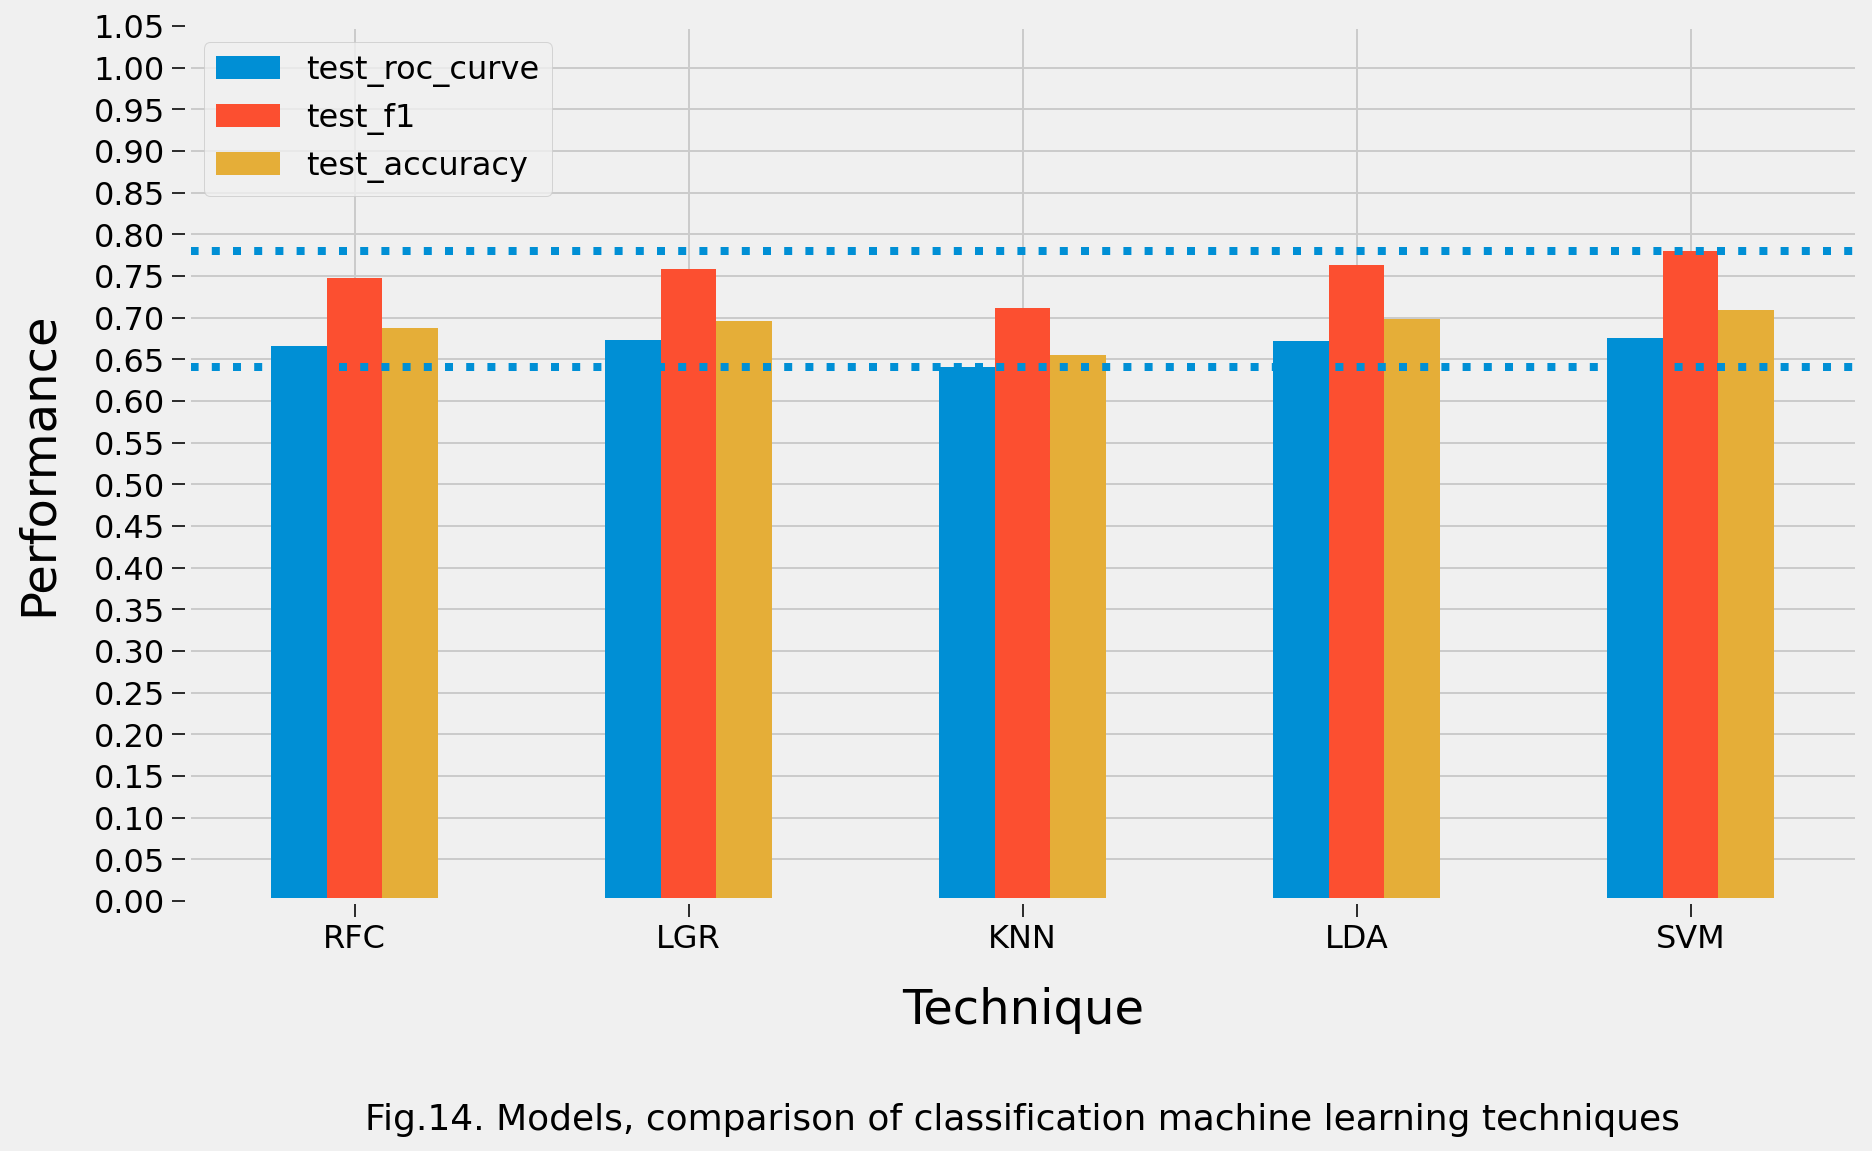

In [79]:
# Graph performance scores against machine learning techniques
index = list()
performance_all = defaultdict(list)

for i,j in model_results.items():
    index.append(i)
    for k,v in j.items():
        performance_all[k].append(np.mean(v))

performance = {k: performance_all[k] for k in performance_all.keys() 
               & ['test_roc_curve', 'test_accuracy', 'test_f1']}
        
df_temp = pd.DataFrame(performance, index=index)

fig,ax = plt.subplots(figsize=(13.33, 7.5))
df_temp.plot.bar(rot=0, ax=ax)
ax.hlines(min(df_temp.min()),-1,5, linestyles='dotted')
ax.hlines(max(df_temp.max()),-1,5, linestyles='dotted')
ax.set_yticks(np.arange(0, 1.1, 0.05))

ax.set_xlabel('Technique', size=24, labelpad=16)
ax.set_ylabel('Performance', size=24, labelpad=16)
ax.tick_params(axis='both', labelsize=16, length=8) 
ax.legend(loc='upper left', fontsize=16)

# Add caption
fignum += 1
figtxt = '. ' + 'Models, comparison of classification machine learning techniques'
figcap = 'Fig.' + str(fignum) + figtxt
ax.text(0.5, -0.25, figcap, fontsize=18, ha='center', va='center', transform=ax.transAxes)
plt.savefig('fig' + str(fignum) + '-model-machine-learning-comparison.png', bbox_inches='tight')

plt.show();

ANOVA (ANalysis Of VAriance) is a statistical method used to compare the means of more than 2 groups. The ANOVA null hypothesis is that the means of the groups are equal (no variation in means of the groups), while the ANOVA alternative hypothesis is that at least one group mean is different from the other groups. ANOVA assumes 1) the residuals (experimental error) are normally distributed, 2) variances are equal between techniques (homogeneity), and 3) observations are sampled independently from each other.   

In [80]:
# Create a function to convert cross validation results into a DataFrame
def prep_anova(model_out, key_str):
    """
    Convert cross validation results into a DataFrame
    """
    anova_dict = {}
    for k,v in model_out.items():
        anova_dict[k] = list(v[key_str])
    
    df_dict = pd.DataFrame(anova_dict, columns=list(anova_dict.keys()))
    return df_dict

# Create a function to build an ANOVA table
def build_anova(df_new):
    """
    Take DataFrame input and output results of ANOVA table
    """
    # Reshape the input dataframe suitable for statsmodels package 
    df_stats = pd.melt(df_new.reset_index(), id_vars=['index'], value_vars=list(df1.columns))
    # Replace column names
    df_stats.columns = ['index', 'treatments', 'value']
    # Apply Ordinary Least Squares (OLS) model
    model = ols('value ~ C(treatments)', data=df_stats).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)
    return df_stats

# Create a function to apply Tukey HSD test
def apply_tukey(df_new_stats):
    """
    Apply Tukey HSD test for significant results
    """
    # Perform multiple pairwise comparison (Tukey HSD)
    m_comp = pairwise_tukeyhsd(endog=df_new_stats['value'], groups=df_new_stats['treatments'], alpha=0.05)
    print(m_comp)
    return m_comp

The p-values obtained from ANOVA analysis are significant (p<0.05) for all three metrics, and therefore, we conclude that there are significant differences among techniques. However, ANOVA does not indicate which techniques are significantly different from each other. To know the pairs of significant different techniques, we will perform multiple pairwise comparison (post-hoc comparison) analysis using Tukey HSD test. The results of the Tukey HSD test suggest that the scores for accuracy and f1 were significantly different for the SVM model compared to the other four models (p<0.05). With the exception of KNN (worst performing model), the other classification models did not have statistically different AUC ROC scores.

In [81]:
# Print and evaluate ANOVA tests
for i in ['test_roc_curve', 'test_accuracy', 'test_f1']:
    df1 = prep_anova(model_results, i)
    print('\n ANOVA RESULTS for {}\n'.format(i))
    df2 = build_anova(df1)
    print('\n TUKEY RESULTS for {}\n'.format(i))
    df3 = apply_tukey(df2)


 ANOVA RESULTS for test_roc_curve

                 sum_sq    df          F        PR(>F)
C(treatments)  0.008353   4.0  28.278827  8.979957e-12
Residual       0.003323  45.0        NaN           NaN

 TUKEY RESULTS for test_roc_curve

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   KNN    LDA   0.0315  0.001  0.0206 0.0425   True
   KNN    LGR   0.0333  0.001  0.0224 0.0442   True
   KNN    RFC   0.0256  0.001  0.0147 0.0365   True
   KNN    SVM   0.0349  0.001   0.024 0.0458   True
   LDA    LGR   0.0018    0.9 -0.0092 0.0127  False
   LDA    RFC  -0.0059 0.5379 -0.0168  0.005  False
   LDA    SVM   0.0034    0.9 -0.0075 0.0143  False
   LGR    RFC  -0.0077 0.2838 -0.0186 0.0032  False
   LGR    SVM   0.0016    0.9 -0.0093 0.0126  False
   RFC    SVM   0.0093 0.1279 -0.0016 0.0202  False
---------------------------------------------------

 ANOVA RESULTS for test_accuracy



<a class="anchor" id="refinement"></a>
## 4.2 Model Refinement 

The SupportVectorClassifier for SVM performed better than the other classification models. To refine the SupportVectorClassifier model, the project uses the RandomizedSearchCV function from scikit-learn to test out various permutations of parameters such as C and gamma. The best estimator result from RandomizedSearchCV was kernel=rbf, gamma=0.1, and C=100. The kernel parameter selects the type of hyperplane used to separate the data (e.g. 'rbf' uses a non-linear hyperplane). Gamma is a parameter for non-linear hyperplanes - the higher the gamma value, the more the SVM model tries to exactly fit the training data set. C is the penalty parameter of the error term and controls the balance between a smooth decision boundary vs classifying the training points correctly (higher C values lead to overfitting). 

In [82]:
# Split into training and test sets for Randomized Search
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# Define model and performance measure
model = SVC(random_state=42)
clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
scoring = ['roc_auc','accuracy','f1']

hyperparameters = {'C': [0.1, 1, 10, 100, 1000],
                   'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}

In [ ]:
# Create randomized search 5-fold cross validation and 100 iterations
# from sklearn.model_selection import RandomizedSearchCV
rand_clf = RandomizedSearchCV(clf, hyperparameters, random_state=42, 
                              n_iter=100, cv=5, verbose=0, n_jobs=-1, 
                              scoring=scoring, refit='roc_auc')

# Fit randomized search
best_mdl = rand_clf.fit(X_train, y_train)

# Identify optimal hyperparameter values
best_gamma = best_mdl.best_params_['gamma']
best_C = best_mdl.best_params_['C']

print("The best performing gamma value is: {}".format(best_gamma))
print("The best performing C value is: {}".format(best_C))

In [84]:
# Predict target vector
model = SVC(random_state=42, C=100, gamma=0.1, probability=True)
clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
best_mdl = clf.fit(X_train, y_train)
y_pred = best_mdl.predict(X_test)

print("----- SVM Classification Report -----")
print(classification_report(y_test, y_pred))
print("----- SVM Confusion Matrix -----")
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

----- SVM Classification Report -----
              precision    recall  f1-score   support

         0.0       0.64      0.55      0.59      3982
         1.0       0.70      0.78      0.74      5479

    accuracy                           0.68      9461
   macro avg       0.67      0.66      0.66      9461
weighted avg       0.68      0.68      0.68      9461

----- SVM Confusion Matrix -----


,Predicted Negative,Predicted Positive
Actual Negative,2178,1804
Actual Positive,1216,4263


From our confusion matrix, we can see that our model got (4136+2234) 6,370 predictions right and got (1804+1287) 3,091 predictions wrong.

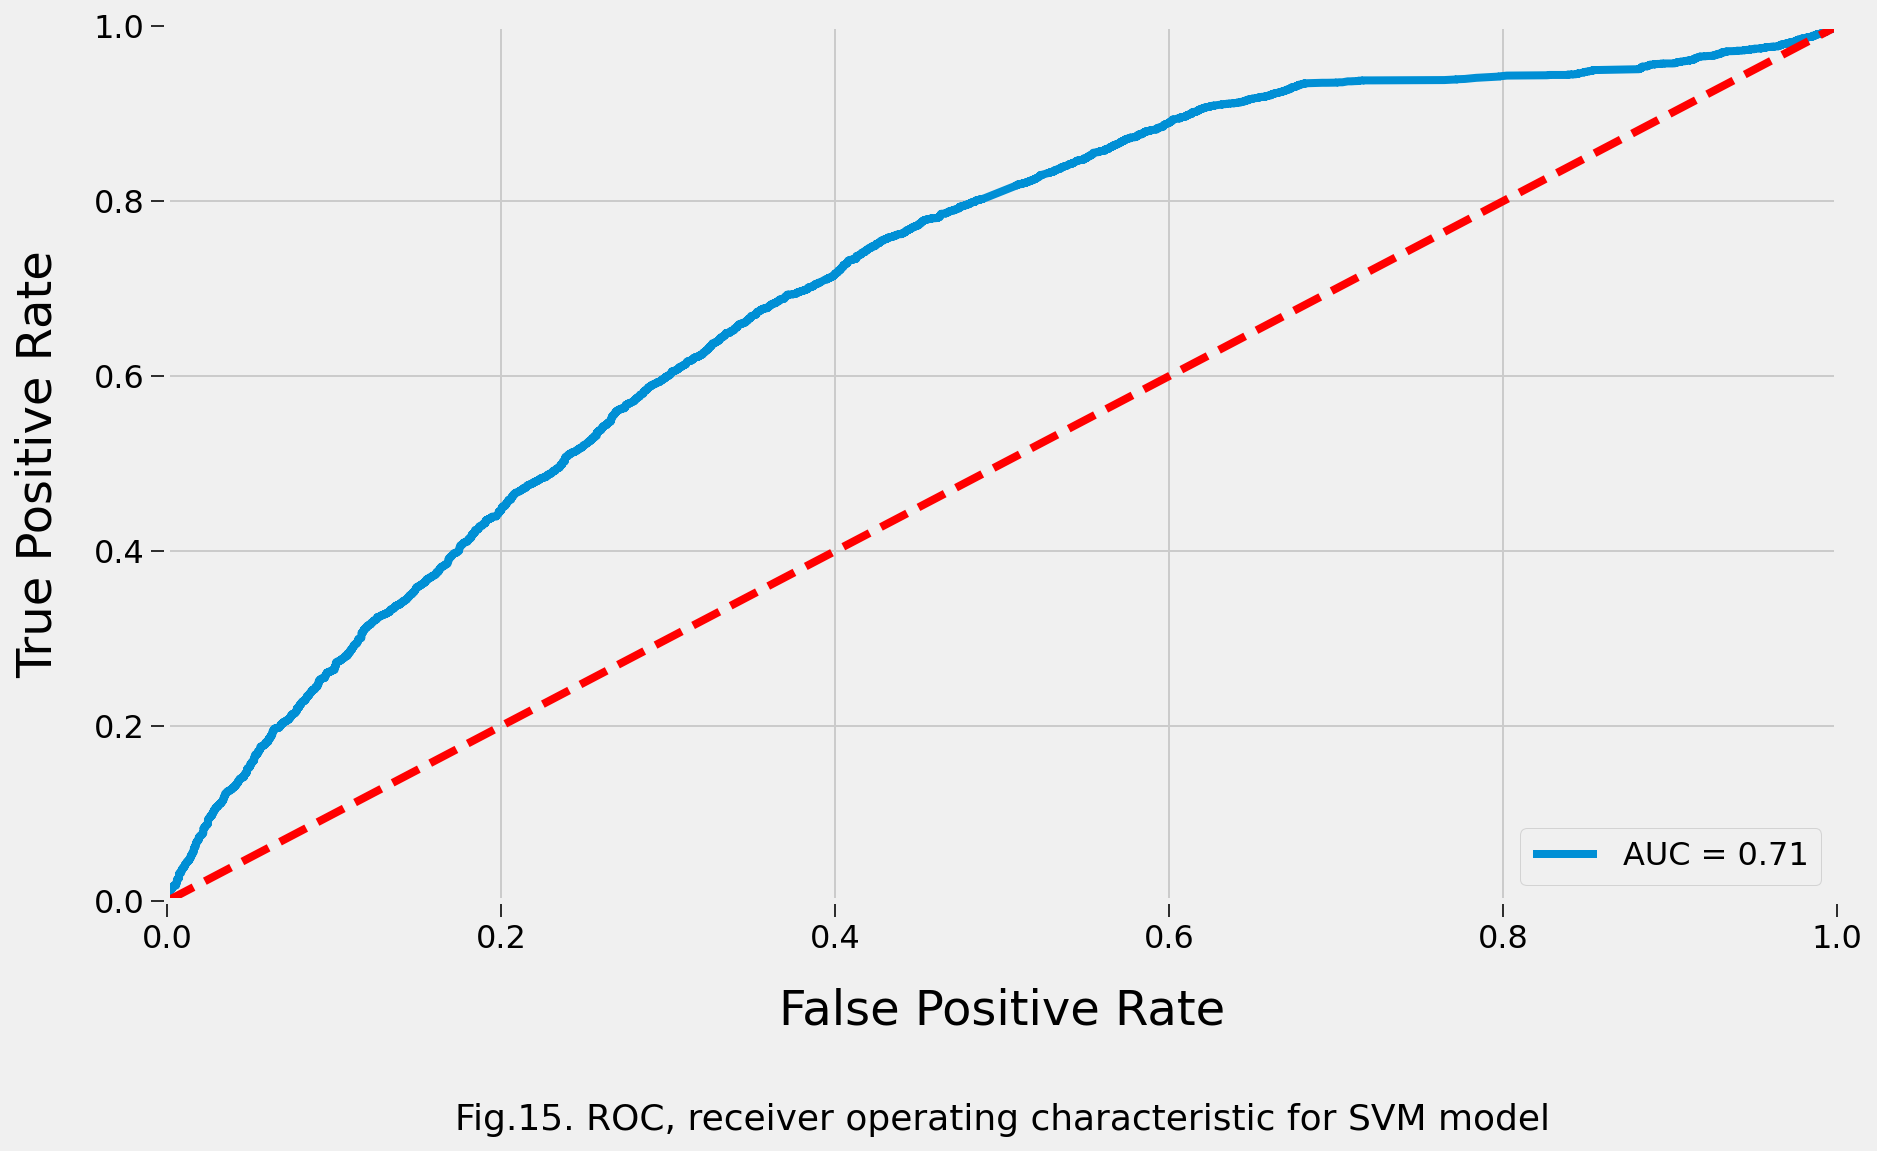

In [85]:
# Graph ROC and calculate AUC
import sklearn.metrics as metrics

probs = clf.predict_proba(X_test)
preds = probs[:,1]

fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

fig,ax = plt.subplots(figsize=(13.33, 7.5))
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot([0, 1], [0, 1],'r--')

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate', size=24, labelpad=16)
ax.set_xlabel('False Positive Rate', size=24, labelpad=16)
ax.tick_params(axis='both', labelsize=16, length=8)
ax.legend(loc='lower right', fontsize=16)

# Add caption
fignum += 1
figtxt = '. ROC, receiver operating characteristic for SVM model'
figcap = 'Fig.' + str(fignum) + figtxt
ax.text(0.5, -0.25, figcap, fontsize=18, ha='center', va='center', transform=ax.transAxes)
plt.savefig('fig' + str(fignum) + '-model-roc-svm-metrics.png', bbox_inches='tight')

plt.show();

An excellent model has AUC near to the 1 which means it has good measure of separability. A poor model has AUC near to the 0 which means it has worst measure of separability. In fact it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means model has no class separation capacity whatsoever. When separability goes down (two distributions overlap), we introduce type 1 and type 2 error. When AUC is 0.71, it means there is a 71% chance the model will be able to distinguish between positive class (long-term LOS) vs. negative class (short-term LOS).

<a class="anchor" id="results"></a>
# 5. Results

From the classification report, we can see that our model has a precision of 70% and a recall of 76% - our model can still do better. From the confusion matrix, we have 1,804 false positives. This means that our model predicted that 1,804 patients would have a long-term LOS whereas these patients actually had a short-term LOS. Taking action on this information would be bad for patient safety because the hospitals could be increasing a patient's risk to hospital-acquired infections by keeping the patient in the hospital longer than necessary. Our model also has 1,287 false negatives. What this means is that our model predicted that these 1,287 patients would have a short-term LOS whereas these patients actually had a long-term LOS. This is also bad for patient safety as hospitals don't want to jeopardize a patient's quality of care by discharging the patient from the hospital too soon.

The ROC curve shows the false positive rate (FPR) against the True Positive rate (TPR). The ideal ROC curve would be at the top left-hand corner of the image at a TPR of 1.0 and FPR of 0.0, our model is slightly above average as it's above the basic threshold which is the red line at 50%. We have an Area Under the Curve of 71% with the final SupportVectorClassifier for SVM model - a 4.4% improvement from the default model.

The SupportVectorClassifier for SVM model demonstrates decent performance (as measured by AUC ROC, accuracy, and F1-Score) for predicting short-term versus long-term hospital stays, especially given that it is a model not specific to a given health condition or group of conditions as has been the case for previous length of stay research results. The model also did not make use of detailed time-stamped physiological patient data, care-giver observations, medication information, laboratory or imaging results, all sources of data that could have a potential predictive bearing on length of stay.

<a class="anchor" id="conclusion"></a>
# 6. Conclusion

In this project, we explored the use of five classification machine learning models to predict the total length of stay of a patient admitted to a hospital. Various patient and admission data were used to predict whether a hospital stay would be short-term (≤ 5 days) or long-term (> 5 days). One of the benefits of this approach was that a relatively simple model in terms of required inputs could be applied across all patients. In addition these inputs were likely captured for all patients via administrative processes rather than clinical data capture or tests. For example, many of the inputs were the demographics of a patient that were necessarily known at the point of admission. The classifiers were trained on the large data set provided by the MIMIC-III database. The SupportVectorClassifier for SVM performed the best with an accuracy of approximately 67% and an AUC-ROC score of approximately 71%. This provides a more general LOS prediction system based on machine learning than has been previously reported.

<a class="anchor" id="acknowledgments"></a>
## Acknowledgments 

MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available from: http://www.nature.com/articles/sdata201635

The project referenced the following resource(s):
* https://microsoft.github.io/r-server-hospital-length-of-stay/
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5898738/
* https://medium.com/@daniel.j.cummings/predicting-hospital-length-of-stay-at-time-of-admission-55dfdfe69598
* https://cmmid.github.io/topics/covid19/los-systematic-review.html
* http://www.tmrfindia.org/ijcsa/v11i33.pdf
* https://www.iit.demokritos.gr/sites/default/files/paper_6.pdf

----------
The Code Caviar is a digital magazine about data science and analytics that dives deep into key topics, so you can experience the thrill of solving at scale.